# Notebook 4: The Transformer Block — From Attention to Architecture

In Notebook 3, we gave the model **eyes** — self-attention lets each token look at its context. But seeing isn't understanding. A model that can only compute weighted averages of its inputs is still fundamentally limited.

This notebook adds three critical components that transform raw attention into a complete, trainable architecture:

| Component | What It Does | Analogy |
|---|---|---|
| **Feed-Forward Network (FFN)** | Processes attended information through nonlinear computation | Attention *gathers* evidence, FFN *reasons* about it |
| **Layer Normalization** | Keeps activations stable during training | Preventing numbers from exploding/vanishing |
| **Residual Connections** | Provides a "highway" for gradients through deep networks | An express lane that bypasses traffic |

We add each one incrementally — training a model after each addition — so you can see exactly how much each component contributes.

## The Embedding Space Perspective

In Notebook 3, attention transformed static token embeddings into context-dependent representations. But the transformation was **linear** — attention computes weighted sums, which can only create new vectors that lie within the span of existing embeddings.

The FFN breaks this limitation with **nonlinearity**. It can push representations to entirely new regions of the embedding space that no linear combination of inputs could reach. Think of it this way:

- **Attention**: "Given these ingredients, blend them together" (linear mixing)
- **FFN**: "Now cook the blended ingredients into something new" (nonlinear transformation)

Together, attention + FFN form a **transformer block** — the fundamental repeating unit of every GPT model. Stack these blocks, and each layer builds more abstract representations on top of the previous one.

## Outline
1. Setup and shared code
2. Feed-Forward Network — adding nonlinearity
3. Layer Normalization — stabilizing training
4. Residual Connections — enabling depth
5. The complete Transformer Block
6. Stacking multiple blocks (depth)
7. Ablation comparison

In [1]:
import os
import re
import json
import math
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['figure.dpi'] = 100

print(f"PyTorch version: {torch.__version__}")
print(f"Device: cpu (intentional for learning)")

PyTorch version: 2.10.0
Device: cpu (intentional for learning)


## 1. Setup: Data, Tokenizer, and Shared Code

Same setup as Notebooks 2 and 3 — same tokenizer, same data split, same evaluation functions. This ensures our ablation comparison is fair: the only thing changing is the model architecture.

In [2]:
# --- BPE Tokenizer (from Notebook 1, with fast pre-tokenized encode) ---

def _pre_tokenize(text):
    """Split text into chunks using GPT-2-style regex."""
    pattern = re.compile(r"'s|'t|'re|'ve|'m|'ll|'d| ?\w+| ?[^\s\w]+|\s+")
    chunks = pattern.findall(text)
    return [chunk.encode("utf-8") for chunk in chunks]

def merge_pair(token_ids, pair, new_id):
    """Replace all occurrences of `pair` in `token_ids` with `new_id`."""
    merged = []
    i = 0
    while i < len(token_ids):
        if i < len(token_ids) - 1 and (token_ids[i], token_ids[i + 1]) == pair:
            merged.append(new_id)
            i += 2
        else:
            merged.append(token_ids[i])
            i += 1
    return merged

class BPETokenizer:
    """Byte-Pair Encoding tokenizer."""
    def __init__(self, merges, vocab):
        self.merges = merges
        self.vocab = vocab

    @property
    def vocab_size(self):
        return len(self.vocab)

    def encode(self, text):
        """Encode text to token IDs (fast: pre-tokenizes into words first)."""
        chunks = _pre_tokenize(text)
        all_ids = []
        for chunk in chunks:
            word = list(chunk)
            for pair, new_id in self.merges:
                word = merge_pair(word, pair, new_id)
            all_ids.extend(word)
        return all_ids

    def decode(self, token_ids):
        """Decode token IDs back to text."""
        return b"".join(self.vocab[id] for id in token_ids).decode("utf-8", errors="replace")

    @classmethod
    def load(cls, path):
        with open(path, "r") as f:
            data = json.load(f)
        merges = [((a, b), new_id) for [a, b], new_id in data["merges"]]
        vocab = {int(k): bytes(v) for k, v in data["vocab"].items()}
        return cls(merges, vocab)

# Load tokenizer and data
tokenizer = BPETokenizer.load(os.path.join("..", "data", "bpe_tokenizer.json"))

with open(os.path.join("..", "data", "tinyshakespeare.txt"), "r") as f:
    raw_text = f.read()

data = torch.tensor(tokenizer.encode(raw_text), dtype=torch.long)
split_idx = int(0.9 * len(data))
train_data = data[:split_idx]
val_data = data[split_idx:]

# Hyperparameters
block_size = 64    # context length
batch_size = 32    # sequences per batch
d_model = 64       # embedding dimension
n_heads = 4        # attention heads
d_ff = 256         # feed-forward hidden dimension (4x d_model — standard ratio)

def get_batch(split):
    """Sample a random batch of (input, target) sequences."""
    d = train_data if split == "train" else val_data
    ix = torch.randint(len(d) - block_size, (batch_size,))
    x = torch.stack([d[i:i + block_size] for i in ix])
    y = torch.stack([d[i + 1:i + block_size + 1] for i in ix])
    return x, y

@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    """Estimate train and val loss by averaging over many batches."""
    model.eval()
    losses = {}
    for split in ["train", "val"]:
        total = 0.0
        for _ in range(eval_iters):
            xb, yb = get_batch(split)
            _, loss = model(xb, yb)
            total += loss.item()
        losses[split] = total / eval_iters
    model.train()
    return losses

def train_model(model, max_steps=5000, lr=1e-3, eval_interval=500):
    """Train a model and return loss history."""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    step_losses = []
    eval_losses = []

    n_params = sum(p.numel() for p in model.parameters())
    print(f"Training {model.__class__.__name__} ({n_params:,} params) for {max_steps:,} steps...")
    print(f"  batch_size={batch_size}, block_size={block_size}, lr={lr}")
    print(f"\n{'Step':>6} {'Train Loss':>12} {'Val Loss':>12}")
    print("-" * 32)

    for step in range(max_steps):
        if step % eval_interval == 0 or step == max_steps - 1:
            losses = estimate_loss(model)
            eval_losses.append((step, losses["train"], losses["val"]))
            print(f"{step:>6} {losses['train']:>12.4f} {losses['val']:>12.4f}")

        xb, yb = get_batch("train")
        _, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        step_losses.append((step, loss.item()))

    final_train = eval_losses[-1][1]
    final_val = eval_losses[-1][2]
    print(f"\nFinal train loss: {final_train:.4f}")
    print(f"Final val loss:   {final_val:.4f}")

    return step_losses, eval_losses

print(f"Data: {len(train_data):,} train, {len(val_data):,} val tokens")
print(f"Config: vocab={tokenizer.vocab_size}, block_size={block_size}, d_model={d_model}")
print(f"        n_heads={n_heads}, d_ff={d_ff} (4x d_model)")

Data: 511,742 train, 56,861 val tokens
Config: vocab=512, block_size=64, d_model=64
        n_heads=4, d_ff=256 (4x d_model)


In [3]:
# Multi-head attention (from Notebook 3 — reused as building block)

class MultiHeadAttention(nn.Module):
    """Multi-head self-attention with causal mask."""

    def __init__(self, d_model, n_heads, block_size, dropout=0.0):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.W_qkv = nn.Linear(d_model, 3 * d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size, dtype=torch.bool)))

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.W_qkv(x)
        Q, K, V = qkv.chunk(3, dim=-1)
        Q = Q.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        attn = (Q @ K.transpose(-2, -1)) / math.sqrt(self.d_k)
        attn = attn.masked_fill(~self.mask[:T, :T], float("-inf"))
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)
        out = attn @ V
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.W_o(out)
        out = self.resid_dropout(out)
        return out

print("MultiHeadAttention loaded from Notebook 3.")
print(f"  {n_heads} heads, d_k = {d_model // n_heads} per head")

MultiHeadAttention loaded from Notebook 3.
  4 heads, d_k = 16 per head


## 2. Feed-Forward Network: Why Attention Alone Isn't Enough

Attention lets tokens gather information from context. But there's a problem: **attention is a linear operation.**

A weighted sum of vectors is just another linear combination:
$$\text{output}_i = \sum_j \alpha_{ij} \cdot V_j$$

No matter how clever the weights are, the output is always a point that lies within the **convex hull** of the value vectors. The model can blend existing representations, but it can't create fundamentally new features.

### What FFN Adds: Nonlinearity

The feed-forward network applies a **nonlinear transformation** to each token's representation independently:

$$\text{FFN}(x) = \text{GELU}(x \cdot W_1 + b_1) \cdot W_2 + b_2$$

This has two key properties:

1. **Nonlinearity (GELU activation)**: Can compute functions that linear operations cannot. For example, detecting "this token is BOTH a noun AND follows a preposition" requires a nonlinear combination of features.

2. **Expand-then-compress bottleneck**: The hidden layer has `d_ff = 4 × d_model` dimensions (256 vs 64). This expansion creates a much larger feature space for the nonlinear computation, then compresses back to `d_model` for the next layer.

### The Intuition

Think of attention and FFN as two phases:
- **Attention**: "Gather the evidence" — look at context, pull in relevant information
- **FFN**: "Process the evidence" — combine features nonlinearly to compute new, more useful representations

Without FFN, the model can see its context but can't deeply reason about what it sees.

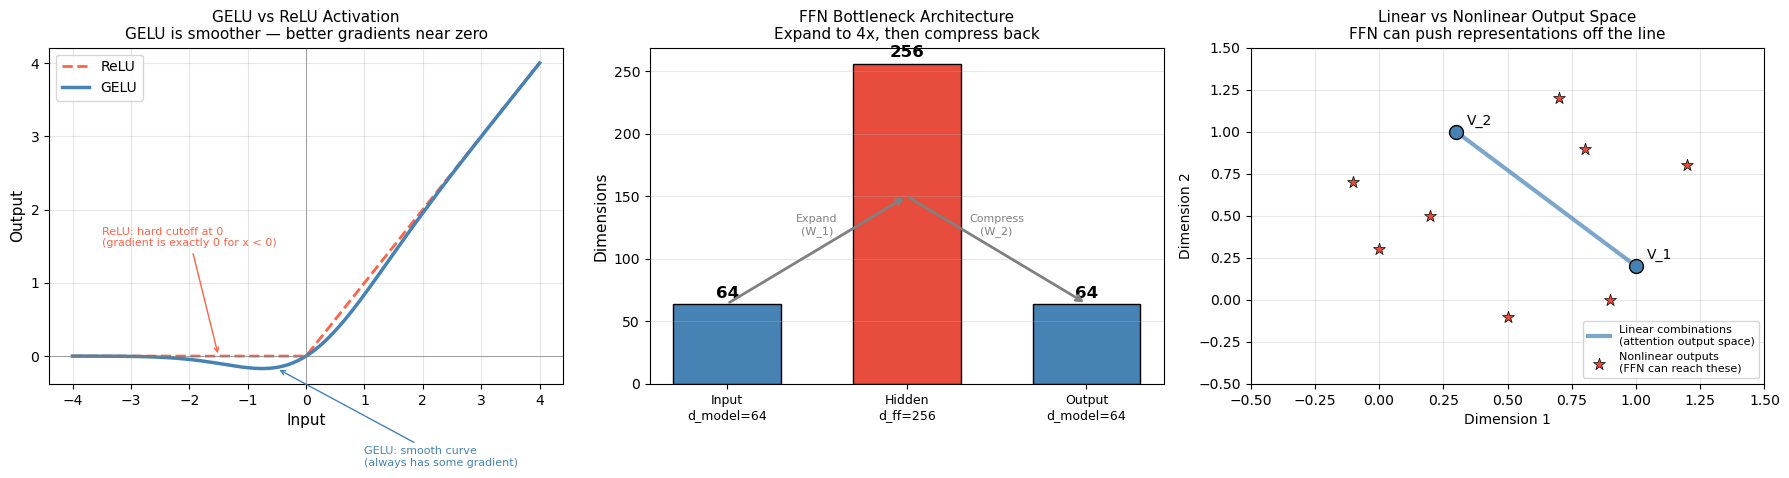

Left: GELU is the activation function used in GPT-2 and later. It's smoother than ReLU,
  which means gradients flow better during training (no 'dead neurons').

Middle: FFN expands from 64 to 256 dimensions (4x), applies GELU, then compresses back.
  The expansion gives the nonlinearity a richer space to work in.

Right: Attention outputs always lie on the line between value vectors (linear combinations).
  FFN can push representations to entirely new locations (red stars) off that line.


In [4]:
# Visualize: GELU activation function and the expand-compress bottleneck

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: GELU vs ReLU ---
ax = axes[0]
x_range = torch.linspace(-4, 4, 200)
relu_y = F.relu(x_range).numpy()
gelu_y = F.gelu(x_range).numpy()

ax.plot(x_range.numpy(), relu_y, '--', color='tomato', linewidth=2, label='ReLU')
ax.plot(x_range.numpy(), gelu_y, '-', color='steelblue', linewidth=2.5, label='GELU')
ax.axhline(y=0, color='gray', linewidth=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5)
ax.set_xlabel('Input', fontsize=11)
ax.set_ylabel('Output', fontsize=11)
ax.set_title('GELU vs ReLU Activation\nGELU is smoother — better gradients near zero', fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Annotate key difference
ax.annotate('ReLU: hard cutoff at 0\n(gradient is exactly 0 for x < 0)',
            xy=(-1.5, 0), xytext=(-3.5, 1.5),
            arrowprops=dict(arrowstyle='->', color='tomato'),
            fontsize=8, color='tomato')
ax.annotate('GELU: smooth curve\n(always has some gradient)',
            xy=(-0.5, -0.17), xytext=(1, -1.5),
            arrowprops=dict(arrowstyle='->', color='steelblue'),
            fontsize=8, color='steelblue')

# --- Plot 2: Expand-Compress bottleneck ---
ax = axes[1]
layers = ['Input\nd_model=64', 'Hidden\nd_ff=256', 'Output\nd_model=64']
widths = [64, 256, 64]
colors_bar = ['steelblue', '#e74c3c', 'steelblue']

bars = ax.bar(range(3), widths, color=colors_bar, edgecolor='black', linewidth=1, width=0.6)
ax.set_xticks(range(3))
ax.set_xticklabels(layers, fontsize=9)
ax.set_ylabel('Dimensions', fontsize=11)
ax.set_title('FFN Bottleneck Architecture\nExpand to 4x, then compress back', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

for bar, w in zip(bars, widths):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            str(w), ha='center', fontsize=12, fontweight='bold')

# Arrows showing flow
ax.annotate('', xy=(1, 150), xytext=(0, 64),
            arrowprops=dict(arrowstyle='->', lw=2, color='gray'))
ax.annotate('', xy=(2, 64), xytext=(1, 150),
            arrowprops=dict(arrowstyle='->', lw=2, color='gray'))
ax.text(0.5, 120, 'Expand\n(W_1)', ha='center', fontsize=8, color='gray')
ax.text(1.5, 120, 'Compress\n(W_2)', ha='center', fontsize=8, color='gray')

# --- Plot 3: What nonlinearity enables ---
ax = axes[2]
# Show that linear combinations stay on a line, but nonlinear can go anywhere
np.random.seed(42)
# Two "source" vectors (what attention blends)
v1 = np.array([1.0, 0.2])
v2 = np.array([0.3, 1.0])

# Linear combinations (convex hull — where attention outputs live)
alphas = np.linspace(0, 1, 50)
linear_pts = np.array([a * v1 + (1-a) * v2 for a in alphas])
ax.plot(linear_pts[:, 0], linear_pts[:, 1], '-', color='steelblue', linewidth=3,
        label='Linear combinations\n(attention output space)', alpha=0.7)
ax.scatter([v1[0], v2[0]], [v1[1], v2[1]], s=100, color='steelblue', zorder=5, edgecolor='black')
ax.annotate('V_1', (v1[0], v1[1]), textcoords='offset points', xytext=(8, 5), fontsize=10)
ax.annotate('V_2', (v2[0], v2[1]), textcoords='offset points', xytext=(8, 5), fontsize=10)

# Nonlinear transformations (points that FFN can reach)
nonlinear_pts = np.array([
    [0.8, 0.9], [0.2, 0.5], [1.2, 0.8], [0.5, -0.1],
    [0.0, 0.3], [0.9, 0.0], [-0.1, 0.7], [0.7, 1.2]
])
ax.scatter(nonlinear_pts[:, 0], nonlinear_pts[:, 1], s=80, color='#e74c3c', zorder=5,
           marker='*', edgecolor='black', linewidth=0.5,
           label='Nonlinear outputs\n(FFN can reach these)')

ax.set_xlabel('Dimension 1', fontsize=10)
ax.set_ylabel('Dimension 2', fontsize=10)
ax.set_title('Linear vs Nonlinear Output Space\nFFN can push representations off the line', fontsize=11)
ax.legend(fontsize=8, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()

print("Left: GELU is the activation function used in GPT-2 and later. It's smoother than ReLU,")
print("  which means gradients flow better during training (no 'dead neurons').")
print(f"\nMiddle: FFN expands from {d_model} to {d_ff} dimensions (4x), applies GELU, then compresses back.")
print("  The expansion gives the nonlinearity a richer space to work in.")
print("\nRight: Attention outputs always lie on the line between value vectors (linear combinations).")
print("  FFN can push representations to entirely new locations (red stars) off that line.")

In [5]:
class FeedForward(nn.Module):
    """
    Position-wise feed-forward network.

    Applied independently to each token position:
    FFN(x) = GELU(x * W1 + b1) * W2 + b2

    The "position-wise" means: same weights for every position,
    but each token is processed independently (no cross-token interaction).
    That's attention's job.
    """

    def __init__(self, d_model, d_ff, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),      # expand:   64 -> 256
            nn.GELU(),                      # nonlinearity
            nn.Linear(d_ff, d_model),       # compress: 256 -> 64
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

# Count parameters
ffn_test = FeedForward(d_model, d_ff)
ffn_params = sum(p.numel() for p in ffn_test.parameters())
print(f"FeedForward architecture: Linear({d_model}->{d_ff}) -> GELU -> Linear({d_ff}->{d_model})")
print(f"Parameters: {ffn_params:,}")
print(f"  W1: {d_model}x{d_ff} + bias {d_ff} = {d_model*d_ff + d_ff:,}")
print(f"  W2: {d_ff}x{d_model} + bias {d_model} = {d_ff*d_model + d_model:,}")
print(f"\nNote: FFN has MORE parameters than attention ({ffn_params:,} vs {d_model*3*d_model + d_model*d_model:,})")
print("This is typical — in most transformers, the FFN is the largest component per block.")

FeedForward architecture: Linear(64->256) -> GELU -> Linear(256->64)
Parameters: 33,088
  W1: 64x256 + bias 256 = 16,640
  W2: 256x64 + bias 64 = 16,448

Note: FFN has MORE parameters than attention (33,088 vs 16,384)
This is typical — in most transformers, the FFN is the largest component per block.


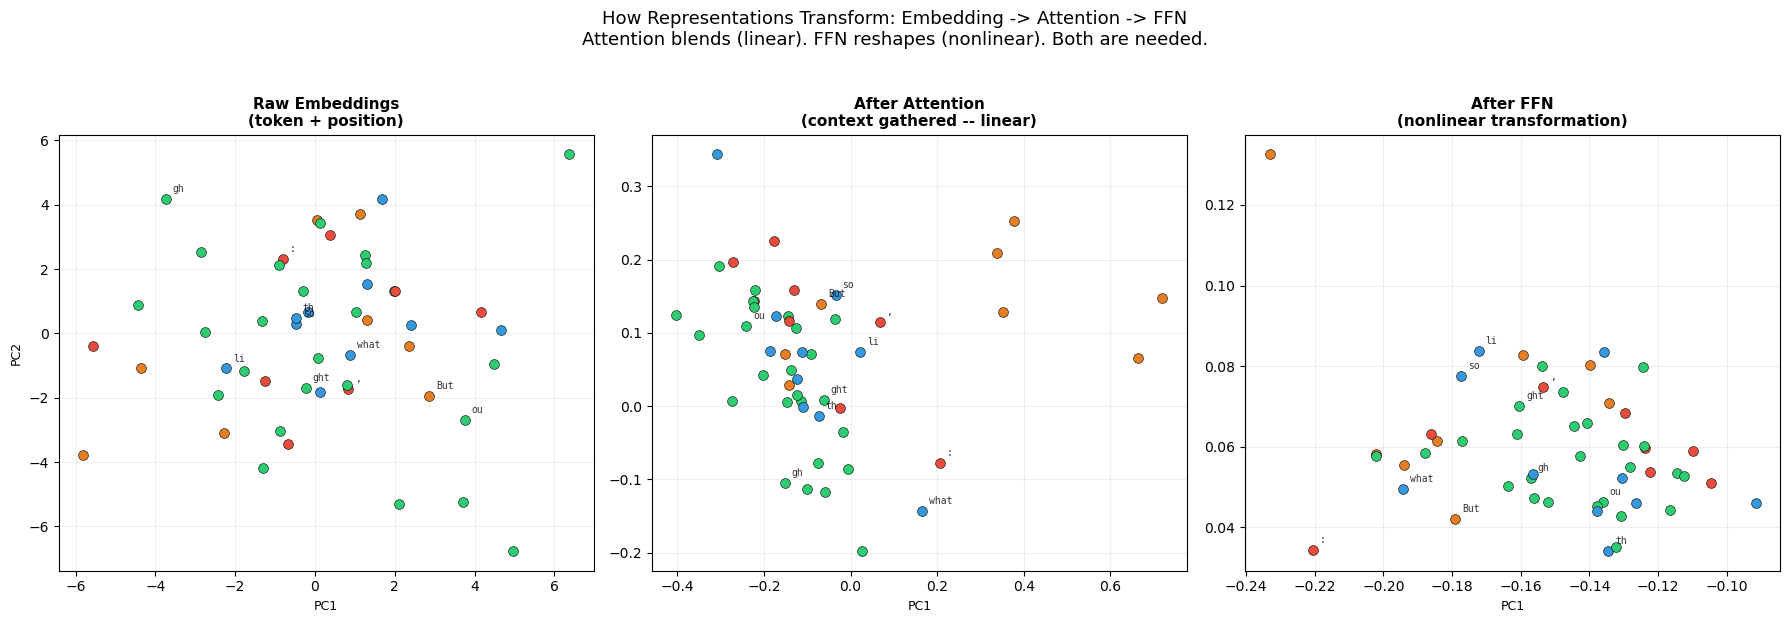

Left:   Raw embeddings -- tokens positioned by identity (what they are)
Middle: After attention -- tokens have been blended with context (linear mixing)
        Notice: the overall structure is similar to raw embeddings
        because weighted sums can only create points BETWEEN existing points.
Right:  After FFN -- tokens have been nonlinearly transformed.
        The FFN can push tokens to entirely new regions of the space.

This is why both attention AND FFN are needed:
  Attention gathers the right information (WHO to listen to)
  FFN processes that information (WHAT to do with it)


In [6]:
# Visualize: what representations look like AFTER attention but BEFORE FFN
# vs AFTER FFN. This shows exactly what the FFN adds.

torch.manual_seed(42)

def pca_2d(data_tensor):
    """Project data to 2D using torch.pca_lowrank (avoids sklearn BLAS conflict)."""
    x = data_tensor.float()
    x_centered = x - x.mean(dim=0)
    U, S, V = torch.pca_lowrank(x_centered, q=2)
    return (x_centered @ V[:, :2]).numpy()

# Use a Shakespeare passage
viz_text = """ROMEO:
But soft, what light through yonder window breaks?
It is the east, and Juliet is the sun."""
viz_ids = tokenizer.encode(viz_text)[:block_size]  # ensure fits in positional embeddings
viz_tokens = [tokenizer.vocab[id].decode('utf-8', errors='replace') for id in viz_ids]
T_viz = len(viz_ids)

# Build components (random weights — shows structural effect of each operation)
tok_emb_viz = nn.Embedding(tokenizer.vocab_size, d_model)
pos_emb_viz = nn.Embedding(block_size, d_model)
attn_viz = MultiHeadAttention(d_model, n_heads, block_size)
ffn_viz = FeedForward(d_model, d_ff)

with torch.no_grad():
    idx_viz = torch.tensor([viz_ids])
    
    # Step 1: Raw embeddings (before anything)
    x_raw = tok_emb_viz(idx_viz) + pos_emb_viz(torch.arange(T_viz))
    
    # Step 2: After attention (gathered context, but still linear)
    x_after_attn = attn_viz(x_raw)
    
    # Step 3: After FFN (nonlinear transformation)
    x_after_ffn = ffn_viz(x_after_attn)

# Categorize tokens for coloring
viz_colors = []
for tok in viz_tokens:
    if tok.strip() in '.,;:!?-':
        viz_colors.append('#e74c3c')       # punctuation: red
    elif '\n' in tok:
        viz_colors.append('#9b59b6')       # newline: purple
    elif tok.strip() and tok.strip()[0].isupper():
        viz_colors.append('#e67e22')       # uppercase: orange
    elif tok.startswith(' ') and len(tok.strip()) > 1:
        viz_colors.append('#3498db')       # words: blue
    else:
        viz_colors.append('#2ecc71')       # other: green

# PCA project all three to 2D (shared PCA for comparability)
all_stacked = torch.cat([x_raw[0], x_after_attn[0], x_after_ffn[0]], dim=0)
all_centered = all_stacked - all_stacked.mean(dim=0)
U, S, V = torch.pca_lowrank(all_centered, q=2)
all_2d = (all_centered @ V[:, :2]).numpy()

raw_2d = all_2d[:T_viz]
attn_2d = all_2d[T_viz:2*T_viz]
ffn_2d = all_2d[2*T_viz:]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

stages = [
    ('Raw Embeddings\n(token + position)', raw_2d),
    ('After Attention\n(context gathered -- linear)', attn_2d),
    ('After FFN\n(nonlinear transformation)', ffn_2d),
]

for ax, (title, coords) in zip(axes, stages):
    for i in range(T_viz):
        ax.scatter(coords[i, 0], coords[i, 1],
                   c=viz_colors[i], s=50, edgecolor='black', linewidth=0.4, zorder=3)
    
    # Label some tokens
    labeled = set()
    for i in range(T_viz):
        tok_clean = viz_tokens[i].strip()
        if tok_clean and tok_clean not in labeled and len(labeled) < 10:
            if len(tok_clean) > 1 or tok_clean in '.,;:!?':
                ax.annotate(tok_clean, (coords[i, 0], coords[i, 1]),
                            textcoords='offset points', xytext=(5, 5),
                            fontsize=7, fontfamily='monospace', alpha=0.8)
                labeled.add(tok_clean)
    
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.2)
    ax.set_xlabel('PC1', fontsize=9)

axes[0].set_ylabel('PC2', fontsize=9)

plt.suptitle('How Representations Transform: Embedding -> Attention -> FFN\n'
             'Attention blends (linear). FFN reshapes (nonlinear). Both are needed.',
             fontsize=13, y=1.03)
plt.tight_layout()
plt.show()

print("Left:   Raw embeddings -- tokens positioned by identity (what they are)")
print("Middle: After attention -- tokens have been blended with context (linear mixing)")
print("        Notice: the overall structure is similar to raw embeddings")
print("        because weighted sums can only create points BETWEEN existing points.")
print("Right:  After FFN -- tokens have been nonlinearly transformed.")
print("        The FFN can push tokens to entirely new regions of the space.")
print("\nThis is why both attention AND FFN are needed:")
print("  Attention gathers the right information (WHO to listen to)")
print("  FFN processes that information (WHAT to do with it)")

In [8]:
class AttnFFNModel(nn.Module):
    """Multi-head attention + FFN (no LayerNorm, no residuals yet)."""

    def __init__(self, vocab_size, d_model, n_heads, d_ff, block_size):
        super().__init__()
        self.block_size = block_size
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(block_size, d_model)
        self.attn = MultiHeadAttention(d_model, n_heads, block_size)
        self.ffn = FeedForward(d_model, d_ff)    # NEW
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        x = self.token_emb(idx) + self.pos_emb(torch.arange(T))
        x = self.attn(x)          # gather context
        x = self.ffn(x)           # NEW: process the gathered context
        logits = self.head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
        return idx

torch.manual_seed(42)
model_ffn = AttnFFNModel(tokenizer.vocab_size, d_model, n_heads, d_ff, block_size)
n_params_ffn = sum(p.numel() for p in model_ffn.parameters())
print(f"Attention + FFN model: {n_params_ffn:,} parameters")
print(f"\nTraining...")
step_losses_ffn, eval_losses_ffn = train_model(model_ffn, max_steps=10000, lr=1e-3)

Attention + FFN model: 119,616 parameters

Training...
Training AttnFFNModel (119,616 params) for 10,000 steps...
  batch_size=32, block_size=64, lr=0.001

  Step   Train Loss     Val Loss
--------------------------------
     0       6.2440       6.2461
   500       4.2311       4.2309
  1000       3.8478       3.9282
  1500       3.6767       3.8251
  2000       3.5695       3.7480
  2500       3.4887       3.6961
  3000       3.4254       3.6617
  3500       3.3581       3.6230
  4000       3.2926       3.5681
  4500       3.2223       3.5208
  5000       3.1558       3.4706
  5500       3.1013       3.4339
  6000       3.0590       3.4083
  6500       3.0110       3.3872
  7000       2.9822       3.3582
  7500       2.9641       3.3391
  8000       2.9506       3.3236
  8500       2.9130       3.3197
  9000       2.8896       3.3044
  9500       2.8828       3.2747
  9999       2.8654       3.2947

Final train loss: 2.8654
Final val loss:   3.2947


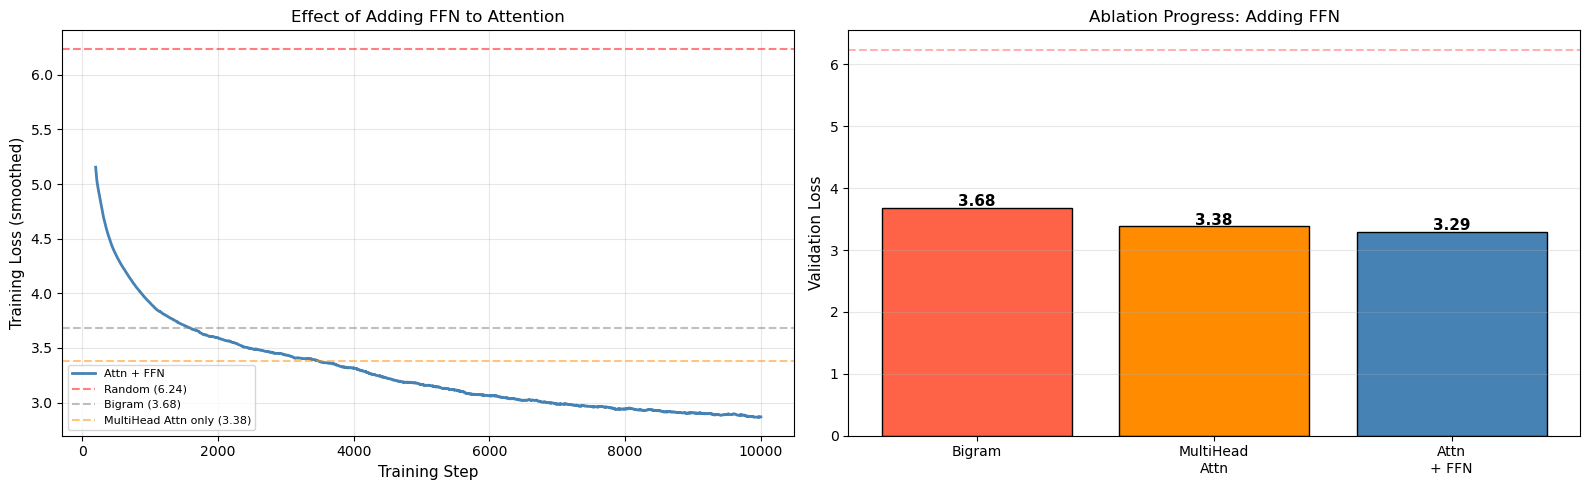

MultiHead Attention only: 3.3818
+ FFN:                    3.2947  (+2.6%)

FFN adds nonlinear processing power — the model can now 'think' about the
context it gathered, not just blend it together.


In [9]:
# Load previous results for comparison
metrics_path = os.path.join("..", "data", "ablation_metrics.json")
with open(metrics_path) as f:
    all_metrics = json.load(f)

bigram_val = next(m["val_loss"] for m in all_metrics if m["model"] == "Bigram")
mh_val = next(m["val_loss"] for m in all_metrics if m["model"] == "MultiHead Attention")
random_loss = math.log(tokenizer.vocab_size)

val_loss_ffn = eval_losses_ffn[-1][2]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Training loss ---
ax = axes[0]
steps = [s for s, _ in step_losses_ffn]
losses = [l for _, l in step_losses_ffn]
window = 200
if len(losses) > window:
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    ax.plot(steps[window-1:], smoothed, color='steelblue', linewidth=2, label='Attn + FFN')

ax.axhline(y=random_loss, color='red', linestyle='--', alpha=0.5, label=f'Random ({random_loss:.2f})')
ax.axhline(y=bigram_val, color='gray', linestyle='--', alpha=0.5, label=f'Bigram ({bigram_val:.2f})')
ax.axhline(y=mh_val, color='darkorange', linestyle='--', alpha=0.5, label=f'MultiHead Attn only ({mh_val:.2f})')
ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Training Loss (smoothed)', fontsize=11)
ax.set_title('Effect of Adding FFN to Attention', fontsize=12)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# --- Bar comparison ---
ax = axes[1]
models_so_far = ['Bigram', 'MultiHead\nAttn', 'Attn\n+ FFN']
vals = [bigram_val, mh_val, val_loss_ffn]
colors_bar = ['tomato', 'darkorange', 'steelblue']

bars = ax.bar(range(len(models_so_far)), vals, color=colors_bar, edgecolor='black', linewidth=1)
for bar, v in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
            f'{v:.2f}', ha='center', fontsize=11, fontweight='bold')

ax.axhline(y=random_loss, color='red', linestyle='--', alpha=0.3)
ax.set_xticks(range(len(models_so_far)))
ax.set_xticklabels(models_so_far, fontsize=10)
ax.set_ylabel('Validation Loss', fontsize=11)
ax.set_title('Ablation Progress: Adding FFN', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

ffn_improvement = (mh_val - val_loss_ffn) / mh_val * 100
print(f"MultiHead Attention only: {mh_val:.4f}")
print(f"+ FFN:                    {val_loss_ffn:.4f}  ({ffn_improvement:+.1f}%)")
print(f"\nFFN adds nonlinear processing power — the model can now 'think' about the")
print(f"context it gathered, not just blend it together.")

## 3. Layer Normalization: Stabilizing Training

As we make the model more complex (attention + FFN + eventually multiple layers), a new problem emerges: **activation instability.**

During training, the values flowing through the network can gradually grow larger or smaller with each layer. After many layers:
- **Exploding activations**: Numbers become huge (1e10+), causing NaN losses
- **Vanishing activations**: Numbers shrink to near-zero, killing gradients

### The Fix: Normalize Every Layer

**Layer Normalization** normalizes each token's representation to have mean=0 and variance=1, then applies a learned scale ($\gamma$) and shift ($\beta$):

$$\text{LayerNorm}(x) = \gamma \cdot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$$

Where $\mu$ and $\sigma^2$ are computed **across the d_model dimension** for each individual token.

### Pre-Norm vs Post-Norm

There are two conventions for where to place LayerNorm:

- **Post-norm** (original 2017 paper): `x = LayerNorm(x + sublayer(x))` — normalize after
- **Pre-norm** (GPT-2 and later): `x = x + sublayer(LayerNorm(x))` — normalize before

We use **pre-norm** because it trains more stably (the residual path stays clean). This is the standard in modern transformers.

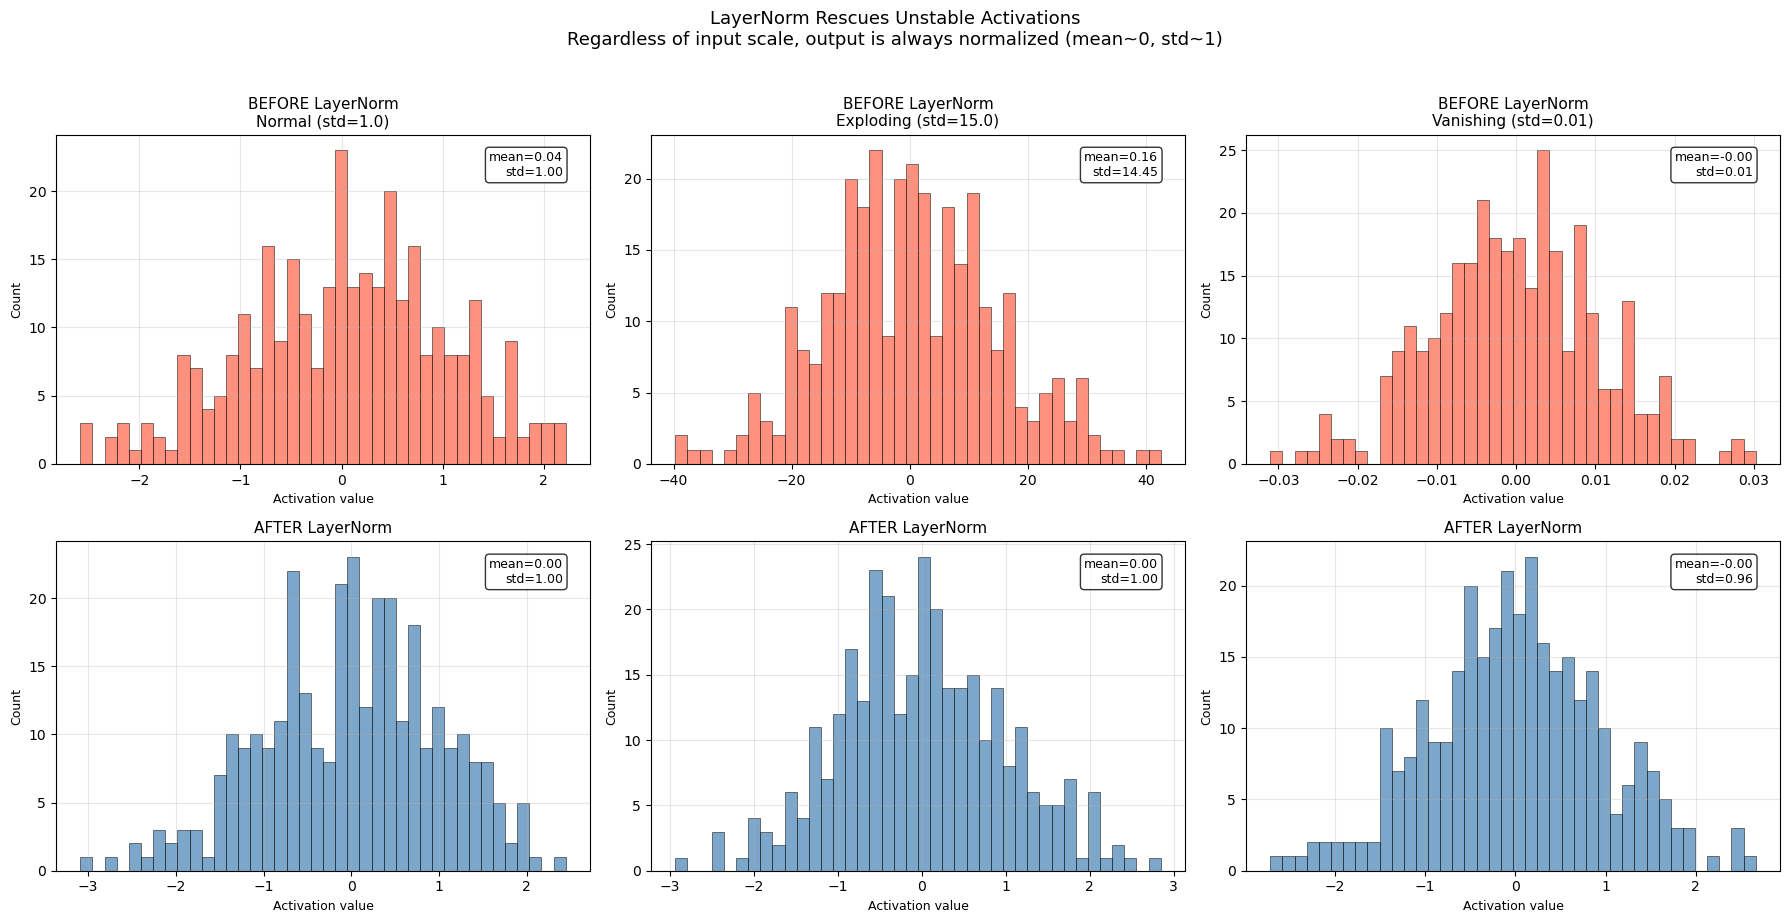

Top row: activations can vary wildly in scale (normal, exploding, vanishing).
Bottom row: after LayerNorm, they ALL look the same — centered at 0, spread of ~1.

This is critical for deep networks: without it, layer 10 might see values of 1e10,
which causes NaN losses and training collapse.


In [10]:
# Visualize: what LayerNorm does to activations

torch.manual_seed(42)

# Simulate activations getting progressively more extreme
# (what happens without normalization in a deep network)
d = d_model
n_tokens = 5
x_normal = torch.randn(n_tokens, d) * 1.0      # well-behaved
x_exploding = torch.randn(n_tokens, d) * 15.0   # simulating exploding activations
x_vanishing = torch.randn(n_tokens, d) * 0.01   # simulating vanishing activations

# Apply LayerNorm
ln = nn.LayerNorm(d)
x_normal_normed = ln(x_normal).detach()
x_exploding_normed = ln(x_exploding).detach()
x_vanishing_normed = ln(x_vanishing).detach()

fig, axes = plt.subplots(2, 3, figsize=(18, 9))

scenarios = [
    ('Normal (std=1.0)', x_normal, x_normal_normed),
    ('Exploding (std=15.0)', x_exploding, x_exploding_normed),
    ('Vanishing (std=0.01)', x_vanishing, x_vanishing_normed),
]

for col, (name, x_before, x_after) in enumerate(scenarios):
    # Before LayerNorm
    ax = axes[0][col]
    ax.hist(x_before.flatten().numpy(), bins=40, color='tomato', edgecolor='black',
            linewidth=0.5, alpha=0.7)
    ax.set_title(f'BEFORE LayerNorm\n{name}', fontsize=11)
    ax.set_xlabel('Activation value', fontsize=9)
    ax.set_ylabel('Count', fontsize=9)
    mean_val = x_before.mean().item()
    std_val = x_before.std().item()
    ax.text(0.95, 0.95, f'mean={mean_val:.2f}\nstd={std_val:.2f}',
            transform=ax.transAxes, ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.grid(True, alpha=0.3)

    # After LayerNorm
    ax = axes[1][col]
    ax.hist(x_after.flatten().numpy(), bins=40, color='steelblue', edgecolor='black',
            linewidth=0.5, alpha=0.7)
    ax.set_title(f'AFTER LayerNorm', fontsize=11)
    ax.set_xlabel('Activation value', fontsize=9)
    ax.set_ylabel('Count', fontsize=9)
    mean_val = x_after.mean().item()
    std_val = x_after.std().item()
    ax.text(0.95, 0.95, f'mean={mean_val:.2f}\nstd={std_val:.2f}',
            transform=ax.transAxes, ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.grid(True, alpha=0.3)

plt.suptitle('LayerNorm Rescues Unstable Activations\n'
             'Regardless of input scale, output is always normalized (mean~0, std~1)',
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

print("Top row: activations can vary wildly in scale (normal, exploding, vanishing).")
print("Bottom row: after LayerNorm, they ALL look the same — centered at 0, spread of ~1.")
print("\nThis is critical for deep networks: without it, layer 10 might see values of 1e10,")
print("which causes NaN losses and training collapse.")

In [11]:
# Implement LayerNorm from scratch to see exactly what's inside

class LayerNormManual(nn.Module):
    """Layer normalization, implemented from scratch."""

    def __init__(self, d_model, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(d_model))   # learned scale
        self.beta = nn.Parameter(torch.zeros(d_model))    # learned shift

    def forward(self, x):
        # For each token independently, normalize across d_model dimensions
        mean = x.mean(dim=-1, keepdim=True)               # (B, T, 1)
        var = x.var(dim=-1, keepdim=True, unbiased=False)  # (B, T, 1)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)   # normalize
        return self.gamma * x_norm + self.beta              # scale and shift

# Verify it matches PyTorch's built-in
torch.manual_seed(42)
x_test = torch.randn(2, 4, d_model)
ln_manual = LayerNormManual(d_model)
ln_torch = nn.LayerNorm(d_model)

out_manual = ln_manual(x_test)
out_torch = ln_torch(x_test)

print("Verification: manual LayerNorm matches PyTorch?",
      torch.allclose(out_manual, out_torch, atol=1e-6))
print(f"\nLayerNorm parameters: just {2 * d_model} (gamma: {d_model}, beta: {d_model})")
print("Tiny overhead — but essential for stable training.")
print("\nKey insight: gamma and beta are LEARNED. The model can undo the normalization")
print("if it wants to. LayerNorm just ensures a stable starting point for each layer.")

Verification: manual LayerNorm matches PyTorch? True

LayerNorm parameters: just 128 (gamma: 64, beta: 64)
Tiny overhead — but essential for stable training.

Key insight: gamma and beta are LEARNED. The model can undo the normalization
if it wants to. LayerNorm just ensures a stable starting point for each layer.


In [13]:
class AttnFFNNormModel(nn.Module):
    """Attention + FFN + LayerNorm (pre-norm). Still no residuals."""

    def __init__(self, vocab_size, d_model, n_heads, d_ff, block_size):
        super().__init__()
        self.block_size = block_size
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(block_size, d_model)
        self.ln1 = nn.LayerNorm(d_model)       # NEW: normalize before attention
        self.attn = MultiHeadAttention(d_model, n_heads, block_size)
        self.ln2 = nn.LayerNorm(d_model)       # NEW: normalize before FFN
        self.ffn = FeedForward(d_model, d_ff)
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        x = self.token_emb(idx) + self.pos_emb(torch.arange(T))
        x = self.attn(self.ln1(x))    # pre-norm: normalize THEN attend
        x = self.ffn(self.ln2(x))     # pre-norm: normalize THEN FFN
        logits = self.head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
        return idx

torch.manual_seed(42)
model_norm = AttnFFNNormModel(tokenizer.vocab_size, d_model, n_heads, d_ff, block_size)
n_params_norm = sum(p.numel() for p in model_norm.parameters())
print(f"Attn + FFN + LayerNorm model: {n_params_norm:,} parameters")
print(f"  (Added only {n_params_norm - n_params_ffn} params for two LayerNorm layers)\n")
step_losses_norm, eval_losses_norm = train_model(model_norm, max_steps=10000, lr=1e-3)

Attn + FFN + LayerNorm model: 119,872 parameters
  (Added only 256 params for two LayerNorm layers)

Training AttnFFNNormModel (119,872 params) for 10,000 steps...
  batch_size=32, block_size=64, lr=0.001

  Step   Train Loss     Val Loss
--------------------------------
     0       6.2471       6.2513
   500       4.0886       4.1247
  1000       3.8067       3.9102
  1500       3.6718       3.8182
  2000       3.5674       3.7491
  2500       3.4689       3.6823
  3000       3.3882       3.6260
  3500       3.3029       3.5653
  4000       3.2278       3.5149
  4500       3.1607       3.4552
  5000       3.1056       3.4168
  5500       3.0630       3.3831
  6000       3.0285       3.3580
  6500       2.9909       3.3483
  7000       2.9634       3.3250
  7500       2.9467       3.2988
  8000       2.9385       3.2786
  8500       2.9063       3.2870
  9000       2.8859       3.2845
  9500       2.8791       3.2538
  9999       2.8597       3.2743

Final train loss: 2.8597
Final val

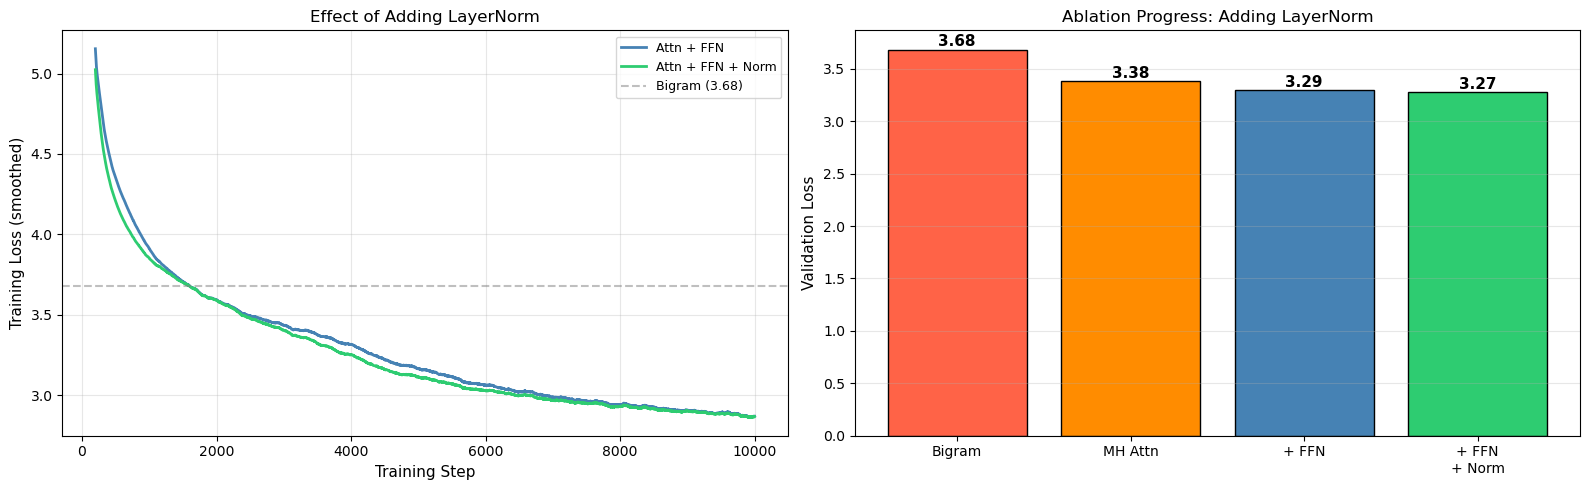

Attn + FFN:              3.2947
Attn + FFN + LayerNorm:  3.2743  (+0.6%)

LayerNorm's impact depends on depth. With just 1 layer, it might be modest.
The real payoff comes when we stack multiple blocks — that's where instability hits hard.


In [14]:
val_loss_norm = eval_losses_norm[-1][2]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Smoothed training loss comparison ---
ax = axes[0]
window = 200
for name, step_losses, color in [
    ('Attn + FFN', step_losses_ffn, 'steelblue'),
    ('Attn + FFN + Norm', step_losses_norm, '#2ecc71'),
]:
    steps = [s for s, _ in step_losses]
    losses = [l for _, l in step_losses]
    if len(losses) > window:
        smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
        ax.plot(steps[window-1:], smoothed, color=color, linewidth=2, label=name)

ax.axhline(y=bigram_val, color='gray', linestyle='--', alpha=0.5, label=f'Bigram ({bigram_val:.2f})')
ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Training Loss (smoothed)', fontsize=11)
ax.set_title('Effect of Adding LayerNorm', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Bar comparison ---
ax = axes[1]
models_bar = ['Bigram', 'MH Attn', '+ FFN', '+ FFN\n+ Norm']
vals = [bigram_val, mh_val, val_loss_ffn, val_loss_norm]
colors_bar = ['tomato', 'darkorange', 'steelblue', '#2ecc71']

bars = ax.bar(range(len(models_bar)), vals, color=colors_bar, edgecolor='black', linewidth=1)
for bar, v in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
            f'{v:.2f}', ha='center', fontsize=11, fontweight='bold')
ax.set_xticks(range(len(models_bar)))
ax.set_xticklabels(models_bar, fontsize=10)
ax.set_ylabel('Validation Loss', fontsize=11)
ax.set_title('Ablation Progress: Adding LayerNorm', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

norm_vs_ffn = (val_loss_ffn - val_loss_norm) / val_loss_ffn * 100
print(f"Attn + FFN:              {val_loss_ffn:.4f}")
print(f"Attn + FFN + LayerNorm:  {val_loss_norm:.4f}  ({norm_vs_ffn:+.1f}%)")
print(f"\nLayerNorm's impact depends on depth. With just 1 layer, it might be modest.")
print(f"The real payoff comes when we stack multiple blocks — that's where instability hits hard.")

## 4. Residual Connections: The Highway for Gradients

We've been doing this: `x = sublayer(x)`. This means the input is completely **replaced** by the sublayer's output. Every layer must perfectly preserve all useful information from the input — if any layer corrupts or loses information, it's gone forever.

**Residual connections** fix this with a simple change: `x = x + sublayer(x)`.

Now the input is **preserved by default**. The sublayer only needs to learn the **delta** — what to *add* to the existing representation. If a sublayer can't learn anything useful, it can learn to output zeros (adding nothing), and the input passes through untouched.

### Why This Enables Depth

During backpropagation, gradients must flow from the loss back through every layer. Without residuals:

```
Gradient path: loss -> layer 4 -> layer 3 -> layer 2 -> layer 1
Each -> multiplies the gradient by that layer's weights.
After 4 multiplications, gradients can shrink to near-zero (vanish).
```

With residuals, there's a **shortcut path** that bypasses layers entirely:

```
Gradient path: loss -> + -> + -> + -> + -> input
The + (addition) passes gradients through with a multiplier of 1.
No matter how deep, gradients always have a clean path to the input.
```

This is what makes training 12, 24, or even 96-layer transformers possible.

### The Complete Pre-Norm Transformer Block

Putting all four components together:

```
x = x + MultiHeadAttention(LayerNorm(x))    ← residual around attention
x = x + FeedForward(LayerNorm(x))           ← residual around FFN
```

Each sublayer:
1. **Normalizes** its input (LayerNorm)
2. **Transforms** it (attention or FFN)
3. **Adds** the result back to the original (residual)

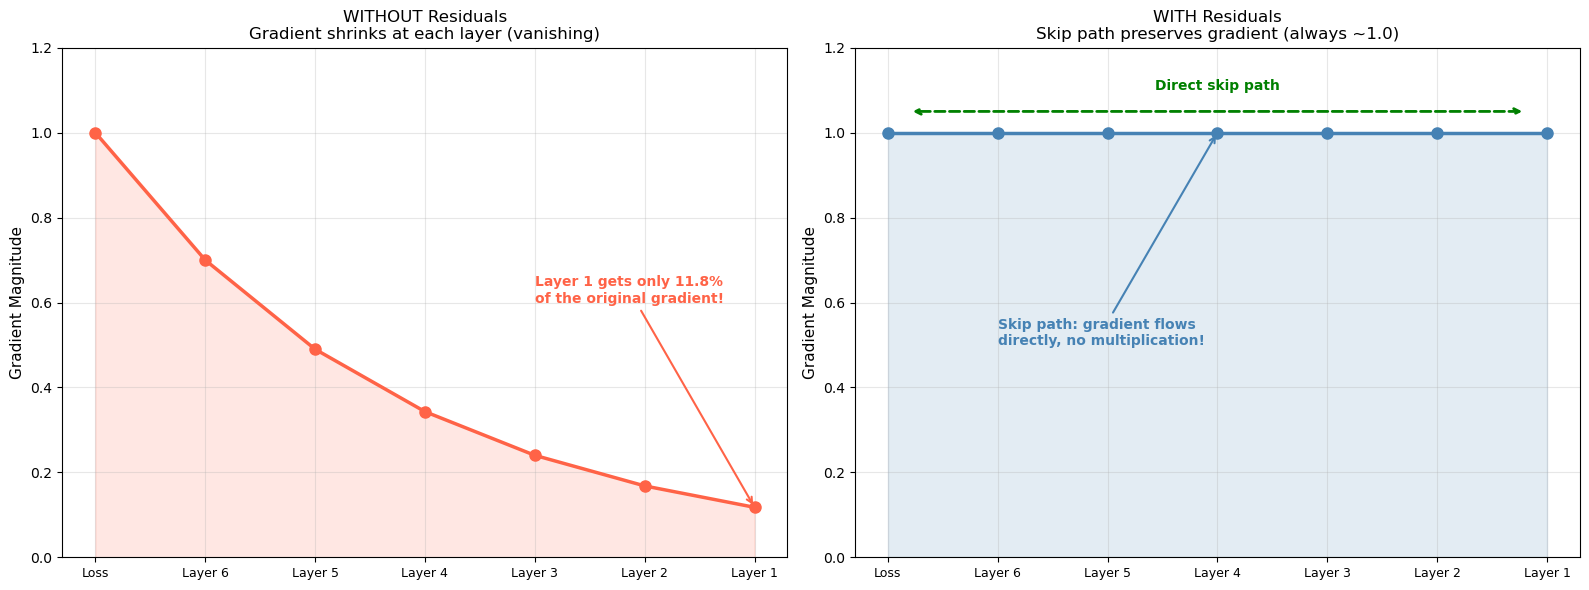

Left: Without residuals, gradients shrink exponentially. After 6 layers,
  early layers get only 12% of the gradient — they barely learn.

Right: With residuals, the skip path carries gradients with multiplier 1.0.
  Every layer gets strong gradients regardless of depth.

This is why residual connections are non-negotiable for deep transformers.
Without them, you simply cannot train models with more than a few layers.


In [15]:
# Visualize: gradient flow with and without residual connections

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Without residuals: gradient vanishes ---
ax = axes[0]
n_layers = 6
gradient_no_resid = [1.0]
for i in range(n_layers):
    # Each layer multiplies gradient by ~0.7 (typical for untrained weights)
    gradient_no_resid.append(gradient_no_resid[-1] * 0.7)

ax.plot(range(n_layers + 1), gradient_no_resid, 'o-', color='tomato', linewidth=2.5, markersize=8)
ax.fill_between(range(n_layers + 1), gradient_no_resid, alpha=0.15, color='tomato')
ax.set_xticks(range(n_layers + 1))
ax.set_xticklabels(['Loss'] + [f'Layer {n_layers-i}' for i in range(n_layers)], fontsize=9)
ax.set_ylabel('Gradient Magnitude', fontsize=11)
ax.set_title('WITHOUT Residuals\nGradient shrinks at each layer (vanishing)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.2)

# Annotate the problem
ax.annotate(f'Layer 1 gets only {gradient_no_resid[-1]:.1%}\nof the original gradient!',
            xy=(n_layers, gradient_no_resid[-1]),
            xytext=(n_layers - 2, 0.6),
            arrowprops=dict(arrowstyle='->', color='tomato', lw=1.5),
            fontsize=10, color='tomato', fontweight='bold')

# --- With residuals: gradient preserved ---
ax = axes[1]
gradient_resid = [1.0]
for i in range(n_layers):
    # Residual: gradient is at LEAST 1.0 (from the skip path) + contribution from layer
    gradient_resid.append(max(1.0, gradient_resid[-1] * 0.7 + 1.0))

# Normalize for visualization
gradient_resid_plot = [1.0] * (n_layers + 1)  # skip path always carries full gradient

ax.plot(range(n_layers + 1), gradient_resid_plot, 'o-', color='steelblue', linewidth=2.5, markersize=8)
ax.fill_between(range(n_layers + 1), gradient_resid_plot, alpha=0.15, color='steelblue')
ax.set_xticks(range(n_layers + 1))
ax.set_xticklabels(['Loss'] + [f'Layer {n_layers-i}' for i in range(n_layers)], fontsize=9)
ax.set_ylabel('Gradient Magnitude', fontsize=11)
ax.set_title('WITH Residuals\nSkip path preserves gradient (always ~1.0)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.2)

# Annotate the solution
ax.annotate('Skip path: gradient flows\ndirectly, no multiplication!',
            xy=(3, 1.0), xytext=(1, 0.5),
            arrowprops=dict(arrowstyle='->', color='steelblue', lw=1.5),
            fontsize=10, color='steelblue', fontweight='bold')

# Draw skip path arrow
ax.annotate('', xy=(0.2, 1.05), xytext=(n_layers - 0.2, 1.05),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2, linestyle='--'))
ax.text(n_layers / 2, 1.1, 'Direct skip path', ha='center', fontsize=10,
        color='green', fontweight='bold')

plt.tight_layout()
plt.show()

print("Left: Without residuals, gradients shrink exponentially. After 6 layers,")
print(f"  early layers get only {gradient_no_resid[-1]:.0%} of the gradient — they barely learn.")
print("\nRight: With residuals, the skip path carries gradients with multiplier 1.0.")
print("  Every layer gets strong gradients regardless of depth.")
print("\nThis is why residual connections are non-negotiable for deep transformers.")
print("Without them, you simply cannot train models with more than a few layers.")

In [16]:
class TransformerBlock(nn.Module):
    """
    A single transformer block: the fundamental building unit of GPT.

    Pre-norm architecture:
        x = x + MultiHeadAttention(LayerNorm(x))    # residual around attention
        x = x + FeedForward(LayerNorm(x))            # residual around FFN
    """

    def __init__(self, d_model, n_heads, d_ff, block_size, dropout=0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model, n_heads, block_size, dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff, dropout)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))   # residual around attention
        x = x + self.ffn(self.ln2(x))    # residual around FFN
        return x

block_test = TransformerBlock(d_model, n_heads, d_ff, block_size)
block_params = sum(p.numel() for p in block_test.parameters())

print("TransformerBlock architecture:")
print("  x -> LayerNorm -> MultiHeadAttention -> + (residual) ->")
print("    -> LayerNorm -> FeedForward         -> + (residual) -> output")
print(f"\nParameters per block: {block_params:,}")
print(f"  LayerNorm x2:  {2 * 2 * d_model:,}")
print(f"  Attention:      {d_model * 3 * d_model + d_model * d_model:,}")
print(f"  FFN:            {d_model * d_ff + d_ff + d_ff * d_model + d_model:,}")

TransformerBlock architecture:
  x -> LayerNorm -> MultiHeadAttention -> + (residual) ->
    -> LayerNorm -> FeedForward         -> + (residual) -> output

Parameters per block: 49,728
  LayerNorm x2:  256
  Attention:      16,384
  FFN:            33,088


In [18]:
class TransformerLM(nn.Module):
    """Language model using N stacked transformer blocks."""

    def __init__(self, vocab_size, d_model, n_heads, d_ff, n_layers, block_size, dropout=0.0):
        super().__init__()
        self.block_size = block_size
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(block_size, d_model)
        self.blocks = nn.Sequential(
            *[TransformerBlock(d_model, n_heads, d_ff, block_size, dropout)
              for _ in range(n_layers)]
        )
        self.ln_f = nn.LayerNorm(d_model)    # final layer norm
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        x = self.token_emb(idx) + self.pos_emb(torch.arange(T))
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
        return idx

# Train 1-block transformer (compare with previous partial models)
torch.manual_seed(42)
model_1b = TransformerLM(tokenizer.vocab_size, d_model, n_heads, d_ff, n_layers=1, block_size=block_size)
n_params_1b = sum(p.numel() for p in model_1b.parameters())
print(f"1-Block Transformer: {n_params_1b:,} parameters")
print(f"  (This is the FULL block: Attn + FFN + LayerNorm + Residuals)\n")
step_losses_1b, eval_losses_1b = train_model(model_1b, max_steps=10000, lr=1e-3)

1-Block Transformer: 120,000 parameters
  (This is the FULL block: Attn + FFN + LayerNorm + Residuals)

Training TransformerLM (120,000 params) for 10,000 steps...
  batch_size=32, block_size=64, lr=0.001

  Step   Train Loss     Val Loss
--------------------------------
     0       6.4128       6.4139
   500       3.7589       3.8696
  1000       3.5488       3.6963
  1500       3.4385       3.6393
  2000       3.3279       3.5748
  2500       3.2393       3.5101
  3000       3.1662       3.4438
  3500       3.0997       3.4054
  4000       3.0536       3.3737
  4500       3.0087       3.3191
  5000       2.9738       3.2975
  5500       2.9436       3.2737
  6000       2.9179       3.2458
  6500       2.8850       3.2364
  7000       2.8672       3.2209
  7500       2.8562       3.1959
  8000       2.8510       3.1918
  8500       2.8204       3.1975
  9000       2.8016       3.1790
  9500       2.7997       3.1512
  9999       2.7841       3.1788

Final train loss: 2.7841
Final val

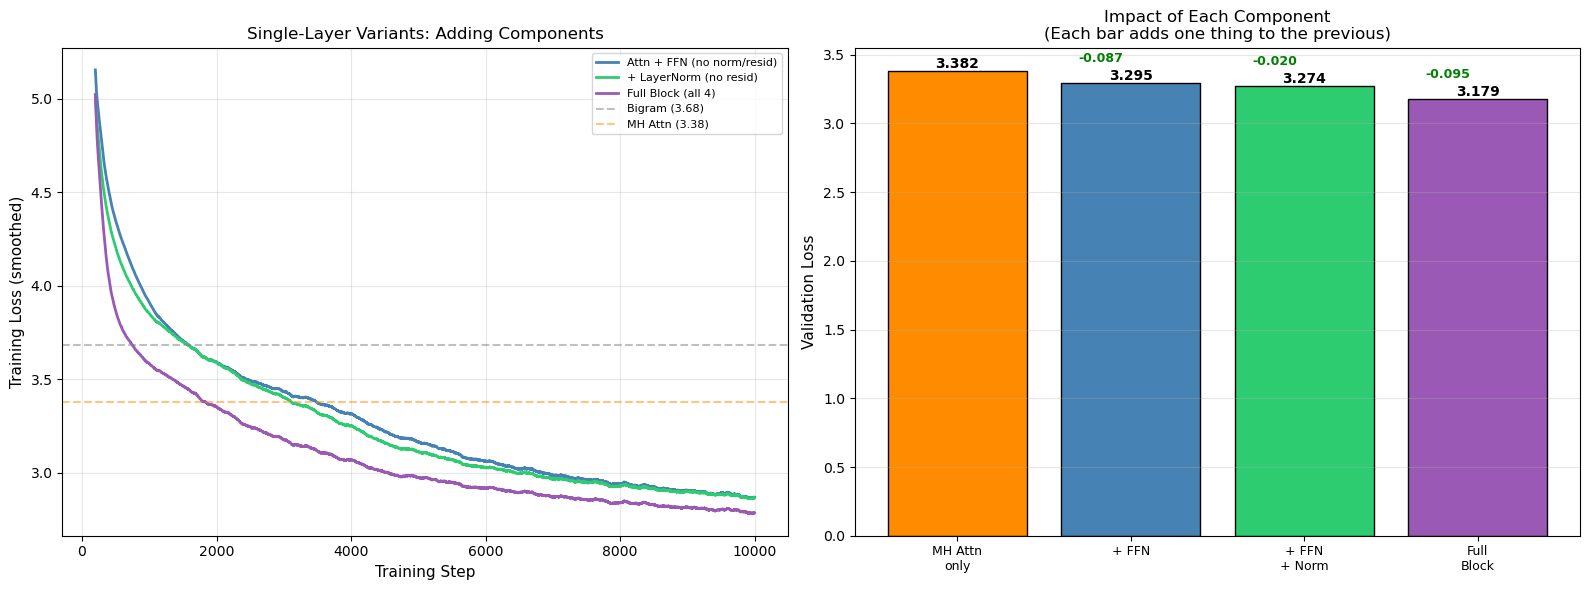

Component-by-component contribution:
  MultiHead Attention:  3.3818  (baseline for this notebook)
  + FFN:                3.2947  (-0.0871)
  + LayerNorm:          3.2743  (-0.1075)
  + Residuals (full):   3.1788  (-0.2030)

The full transformer block combines all four components into a clean, stable architecture.
Now the question: what happens if we stack MULTIPLE blocks?


In [19]:
# Compare ALL single-layer variants we've trained

val_loss_1b = eval_losses_1b[-1][2]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- All training curves ---
ax = axes[0]
window = 200
for name, step_losses, color in [
    ('Attn + FFN (no norm/resid)', step_losses_ffn, 'steelblue'),
    ('+ LayerNorm (no resid)', step_losses_norm, '#2ecc71'),
    ('Full Block (all 4)', step_losses_1b, '#9b59b6'),
]:
    steps = [s for s, _ in step_losses]
    losses = [l for _, l in step_losses]
    if len(losses) > window:
        smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
        ax.plot(steps[window-1:], smoothed, color=color, linewidth=2, label=name)

ax.axhline(y=bigram_val, color='gray', linestyle='--', alpha=0.5, label=f'Bigram ({bigram_val:.2f})')
ax.axhline(y=mh_val, color='darkorange', linestyle='--', alpha=0.5, label=f'MH Attn ({mh_val:.2f})')
ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Training Loss (smoothed)', fontsize=11)
ax.set_title('Single-Layer Variants: Adding Components', fontsize=12)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# --- Component-by-component bar chart ---
ax = axes[1]
components = ['MH Attn\nonly', '+ FFN', '+ FFN\n+ Norm', 'Full\nBlock']
component_vals = [mh_val, val_loss_ffn, val_loss_norm, val_loss_1b]
component_colors = ['darkorange', 'steelblue', '#2ecc71', '#9b59b6']

bars = ax.bar(range(len(components)), component_vals, color=component_colors,
              edgecolor='black', linewidth=1)
for bar, v in zip(bars, component_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

# Show improvement arrows
for i in range(1, len(component_vals)):
    delta = component_vals[i] - component_vals[i-1]
    if delta < 0:
        ax.annotate(f'{delta:.3f}', xy=(i, component_vals[i]),
                    xytext=(i - 0.3, component_vals[i] + 0.15),
                    fontsize=9, color='green', fontweight='bold')

ax.set_xticks(range(len(components)))
ax.set_xticklabels(components, fontsize=9)
ax.set_ylabel('Validation Loss', fontsize=11)
ax.set_title('Impact of Each Component\n(Each bar adds one thing to the previous)', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Component-by-component contribution:")
print(f"  MultiHead Attention:  {mh_val:.4f}  (baseline for this notebook)")
print(f"  + FFN:                {val_loss_ffn:.4f}  ({val_loss_ffn - mh_val:+.4f})")
print(f"  + LayerNorm:          {val_loss_norm:.4f}  ({val_loss_norm - mh_val:+.4f})")
print(f"  + Residuals (full):   {val_loss_1b:.4f}  ({val_loss_1b - mh_val:+.4f})")
print(f"\nThe full transformer block combines all four components into a clean, stable architecture.")
print(f"Now the question: what happens if we stack MULTIPLE blocks?")

## 5. Stacking Multiple Blocks: The Power of Depth

A single transformer block can learn one "round" of attention + processing. But language has **hierarchical structure**:

- **Layer 1**: Learns basic patterns — token co-occurrence, local context
- **Layer 2**: Builds on Layer 1's output — phrase-level patterns, subject-verb relationships
- **Layer 3**: Builds further — clause-level structure, dialogue patterns
- **Layer 4+**: Higher-level abstractions — theme, character consistency, plot

Each block takes the previous block's output as input, applying another round of "attend then process." The residual connections ensure earlier information is preserved while new information is layered on top.

### How Representations Evolve Through Layers

```
Input:  "ROMEO: But soft, what light"
Layer 1: Recognizes "ROMEO:" as a character name pattern
Layer 2: Connects "ROMEO" with romantic vocabulary
Layer 3: Associates "what light" with the famous soliloquy
Layer 4: Predicts continuation in iambic pentameter style
```

Each layer builds a more abstract understanding on top of the previous one. This is the same principle that makes deep CNNs work for vision — shallow layers detect edges, deeper layers detect objects.

### Scaling in Practice

| Model | Layers | Parameters | Quality |
|---|---|---|---|
| Our tiny model | 1-4 | ~100K-300K | Shakespeare-ish fragments |
| GPT-2 Small | 12 | 117M | Coherent paragraphs |
| GPT-2 Large | 36 | 774M | Essays, code |
| GPT-3 | 96 | 175B | Remarkable general ability |

We'll compare 1-block vs 4-block to see the effect of depth on our small model.

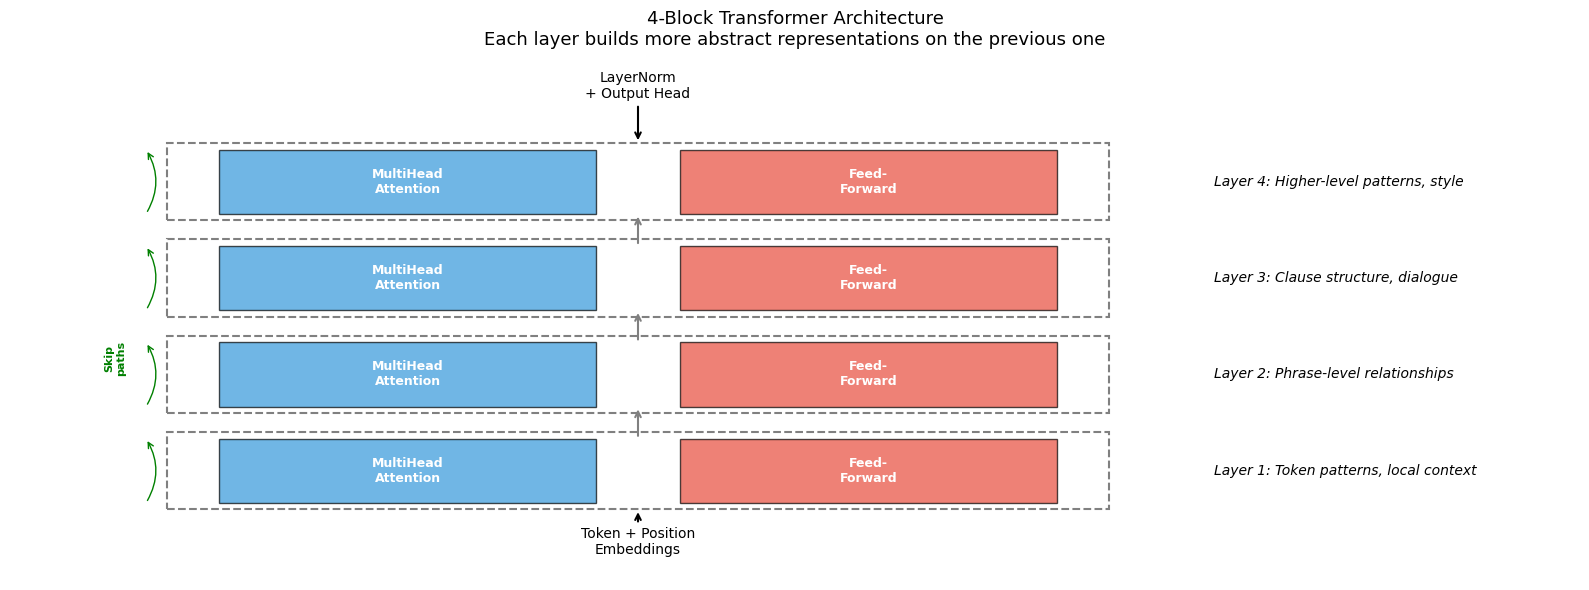

Blue blocks: attention (gather context from other tokens)
Red blocks: FFN (process/transform the gathered information)
Green arrows: residual skip paths (preserve information + enable gradient flow)

Each block has 49,728 parameters.
4 blocks = 198,912 block params + embeddings + output head


In [20]:
# Visualize: what depth enables — each layer refines the representation

fig, ax = plt.subplots(figsize=(16, 6))

n_layers_show = 4
block_height = 1.0
block_width = 8

for layer in range(n_layers_show):
    y = layer * 1.5

    # Attention sub-block
    rect_attn = plt.Rectangle((1, y), block_width * 0.45, block_height,
                               facecolor='#3498db', edgecolor='black', linewidth=1, alpha=0.7)
    ax.add_patch(rect_attn)
    ax.text(1 + block_width * 0.225, y + block_height/2, 'MultiHead\nAttention',
            ha='center', va='center', fontsize=9, fontweight='bold', color='white')

    # FFN sub-block
    rect_ffn = plt.Rectangle((1 + block_width * 0.55, y), block_width * 0.45, block_height,
                              facecolor='#e74c3c', edgecolor='black', linewidth=1, alpha=0.7)
    ax.add_patch(rect_ffn)
    ax.text(1 + block_width * 0.775, y + block_height/2, 'Feed-\nForward',
            ha='center', va='center', fontsize=9, fontweight='bold', color='white')

    # Layer label
    descriptions = [
        'Token patterns, local context',
        'Phrase-level relationships',
        'Clause structure, dialogue',
        'Higher-level patterns, style',
    ]
    ax.text(block_width + 2.5, y + block_height/2,
            f'Layer {layer+1}: {descriptions[layer]}',
            va='center', fontsize=10, fontstyle='italic')

    # Block border
    rect_block = plt.Rectangle((0.5, y - 0.1), block_width + 1, block_height + 0.2,
                                facecolor='none', edgecolor='gray', linewidth=1.5, linestyle='--')
    ax.add_patch(rect_block)

    # Residual arrows (skip connections)
    if layer > 0:
        # Arrow from previous layer
        ax.annotate('', xy=(5, y), xytext=(5, y - 0.5),
                    arrowprops=dict(arrowstyle='->', lw=1.5, color='gray'))

    # Residual skip path (curved arrow on the side)
    ax.annotate('', xy=(0.3, y + block_height), xytext=(0.3, y),
                arrowprops=dict(arrowstyle='->', lw=1, color='green', connectionstyle='arc3,rad=0.3'))

# Input arrow
ax.annotate('Token + Position\nEmbeddings', xy=(5, -0.1), xytext=(5, -0.8),
            ha='center', fontsize=10, arrowprops=dict(arrowstyle='->', lw=1.5))

# Output arrow
top_y = (n_layers_show - 1) * 1.5 + block_height
ax.annotate('LayerNorm\n+ Output Head', xy=(5, top_y + 0.1), xytext=(5, top_y + 0.8),
            ha='center', fontsize=10, arrowprops=dict(arrowstyle='->', lw=1.5))

ax.text(0.0, (n_layers_show - 1) * 0.75, 'Skip\npaths', fontsize=8, color='green',
        ha='center', fontweight='bold', rotation=90, va='center')

ax.set_xlim(-1, 14)
ax.set_ylim(-1.2, top_y + 1.5)
ax.axis('off')
ax.set_title(f'{n_layers_show}-Block Transformer Architecture\n'
             'Each layer builds more abstract representations on the previous one',
             fontsize=13)

plt.tight_layout()
plt.show()

print("Blue blocks: attention (gather context from other tokens)")
print("Red blocks: FFN (process/transform the gathered information)")
print("Green arrows: residual skip paths (preserve information + enable gradient flow)")
print(f"\nEach block has {block_params:,} parameters.")
print(f"4 blocks = {4 * block_params:,} block params + embeddings + output head")

In [22]:
# Train 4-block transformer
torch.manual_seed(42)
model_4b = TransformerLM(
    tokenizer.vocab_size, d_model, n_heads, d_ff,
    n_layers=4, block_size=block_size
)
n_params_4b = sum(p.numel() for p in model_4b.parameters())
print(f"4-Block Transformer: {n_params_4b:,} parameters")
print(f"  ({n_params_4b / n_params_1b:.1f}x the 1-block model)\n")
step_losses_4b, eval_losses_4b = train_model(model_4b, max_steps=10000, lr=1e-3)

4-Block Transformer: 269,184 parameters
  (2.2x the 1-block model)

Training TransformerLM (269,184 params) for 10,000 steps...
  batch_size=32, block_size=64, lr=0.001

  Step   Train Loss     Val Loss
--------------------------------
     0       6.4189       6.4276
   500       3.5869       3.7207
  1000       3.2797       3.5590
  1500       3.0851       3.3927
  2000       2.9334       3.2802
  2500       2.8470       3.2244
  3000       2.7855       3.1766
  3500       2.7393       3.1715
  4000       2.6901       3.1182
  4500       2.6562       3.1090
  5000       2.6288       3.0966
  5500       2.6129       3.0937
  6000       2.5812       3.0855
  6500       2.5785       3.0568
  7000       2.5548       3.0541
  7500       2.5424       3.0561
  8000       2.5291       3.0541
  8500       2.5109       3.0404
  9000       2.5138       3.0671
  9500       2.4934       3.0559
  9999       2.5032       3.0621

Final train loss: 2.5032
Final val loss:   3.0621


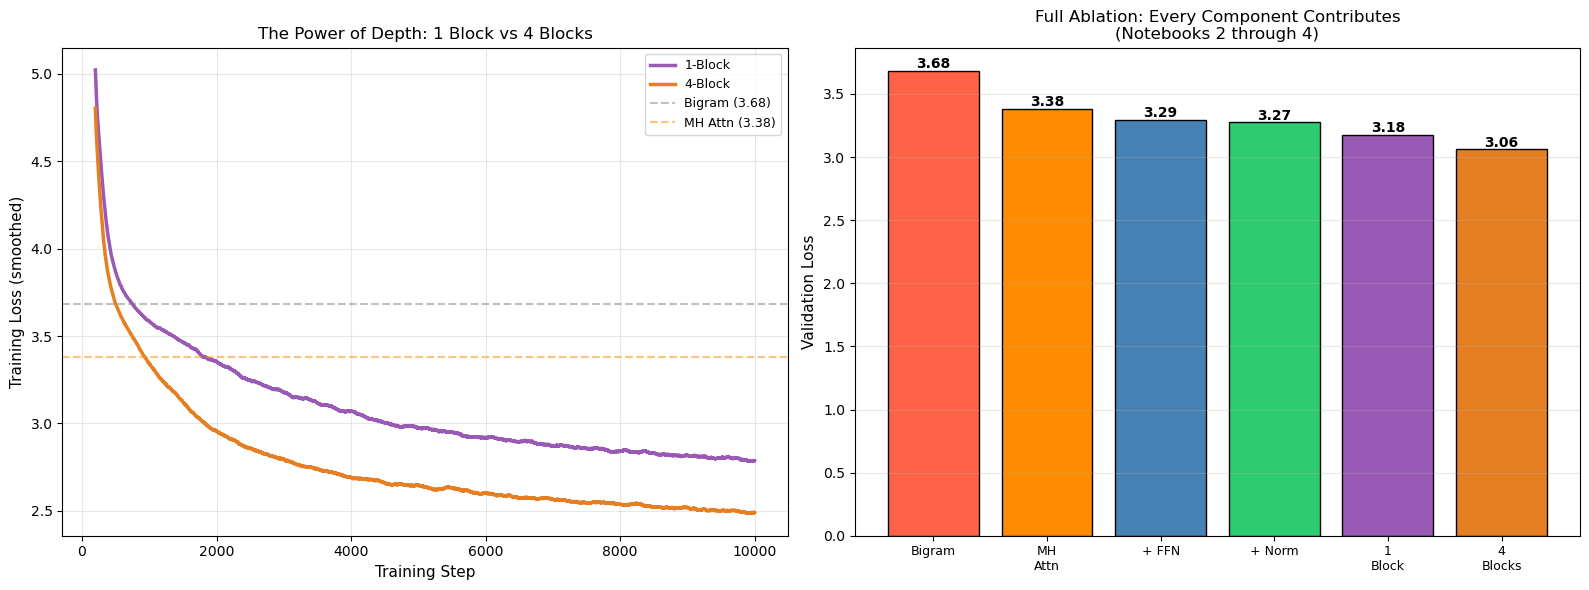

1-Block Transformer: 3.1788  (120,000 params)
4-Block Transformer: 3.0621  (269,184 params)
Depth improvement:   3.7% lower loss

More layers = more rounds of 'attend then process' = richer representations.


In [23]:
val_loss_4b = eval_losses_4b[-1][2]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Depth comparison: 1 block vs 4 blocks ---
ax = axes[0]
window = 200
for name, step_losses, color in [
    ('1-Block', step_losses_1b, '#9b59b6'),
    ('4-Block', step_losses_4b, '#e67e22'),
]:
    steps = [s for s, _ in step_losses]
    losses = [l for _, l in step_losses]
    if len(losses) > window:
        smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
        ax.plot(steps[window-1:], smoothed, color=color, linewidth=2.5, label=name)

ax.axhline(y=bigram_val, color='gray', linestyle='--', alpha=0.5, label=f'Bigram ({bigram_val:.2f})')
ax.axhline(y=mh_val, color='darkorange', linestyle='--', alpha=0.5, label=f'MH Attn ({mh_val:.2f})')
ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Training Loss (smoothed)', fontsize=11)
ax.set_title('The Power of Depth: 1 Block vs 4 Blocks', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Full ablation bar chart ---
ax = axes[1]
all_names = ['Bigram', 'MH\nAttn', '+ FFN', '+ Norm', '1\nBlock', '4\nBlocks']
all_vals = [bigram_val, mh_val, val_loss_ffn, val_loss_norm, val_loss_1b, val_loss_4b]
all_colors = ['tomato', 'darkorange', 'steelblue', '#2ecc71', '#9b59b6', '#e67e22']

bars = ax.bar(range(len(all_names)), all_vals, color=all_colors, edgecolor='black', linewidth=1)
for bar, v in zip(bars, all_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{v:.2f}', ha='center', fontsize=10, fontweight='bold')

ax.set_xticks(range(len(all_names)))
ax.set_xticklabels(all_names, fontsize=9)
ax.set_ylabel('Validation Loss', fontsize=11)
ax.set_title('Full Ablation: Every Component Contributes\n(Notebooks 2 through 4)', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

depth_improvement = (val_loss_1b - val_loss_4b) / val_loss_1b * 100
print(f"1-Block Transformer: {val_loss_1b:.4f}  ({n_params_1b:,} params)")
print(f"4-Block Transformer: {val_loss_4b:.4f}  ({n_params_4b:,} params)")
print(f"Depth improvement:   {depth_improvement:.1f}% lower loss")
print(f"\nMore layers = more rounds of 'attend then process' = richer representations.")

### Visualizing the Embedding Space at Each Layer

Here's a powerful way to see what the transformer is actually doing: take a passage of Shakespeare, run it through the trained 4-block model, and capture the token representations **at every layer**. Then project them to 2D using PCA (via torch.pca_lowrank).

If the model is doing something useful, we should see:
- **Input embeddings (Layer 0)**: Tokens clustered mostly by identity — all instances of "the" are near each other, regardless of context
- **After Layer 1-2**: Clusters start to break apart — the same token in different contexts drifts to different locations
- **After Layer 3-4**: Tokens are organized by **function in context** rather than identity — punctuation separates from words, character names form their own region

This shows the transformer progressively transforming static token identities into rich, context-dependent representations.

In [34]:
# Process a large chunk of Shakespeare through the trained 4-block model
# and capture token representations at every layer for detailed analysis.

big_ids = tokenizer.encode(raw_text[:50000])  # ~3000+ tokens from Shakespeare

# Split into non-overlapping block_size windows
windows = []
for start in range(0, len(big_ids) - block_size, block_size):
    windows.append(big_ids[start:start + block_size])

all_ids_flat = [tid for w in windows for tid in w]
all_tokens = [tokenizer.vocab[tid].decode('utf-8', errors='replace') for tid in all_ids_flat]
T_total = len(all_ids_flat)

print(f"Processing {T_total} tokens ({len(windows)} windows of {block_size})")
print(f"Unique token IDs: {len(set(all_ids_flat))}")

# Run every window through the model, capture representations at each layer
model_4b.eval()
layer_representations = [[] for _ in range(6)]  # input + 4 blocks + final LN
layer_labels = ['Input\nEmbeddings'] + [f'After\nBlock {i+1}' for i in range(4)] + ['After\nFinal LN']

with torch.no_grad():
    for window in windows:
        idx = torch.tensor([window])
        x = model_4b.token_emb(idx) + model_4b.pos_emb(torch.arange(block_size))
        layer_representations[0].append(x[0].clone())
        
        for i, block in enumerate(model_4b.blocks):
            x = block(x)
            layer_representations[i + 1].append(x[0].clone())
        
        x_final = model_4b.ln_f(x)
        layer_representations[5].append(x_final[0].clone())

layer_representations = [torch.cat(parts, dim=0) for parts in layer_representations]
model_4b.train()
n_layers_viz = len(layer_representations)

print(f"Done: {T_total} tokens x {d_model}d at {n_layers_viz} layers")
print(f"\nNow we have the full embedding landscape. Next cell visualizes specific token groups.")

Processing 25408 tokens (397 windows of 64)
Unique token IDs: 306
Done: 25408 tokens x 64d at 6 layers

Now we have the full embedding landscape. Next cell visualizes specific token groups.


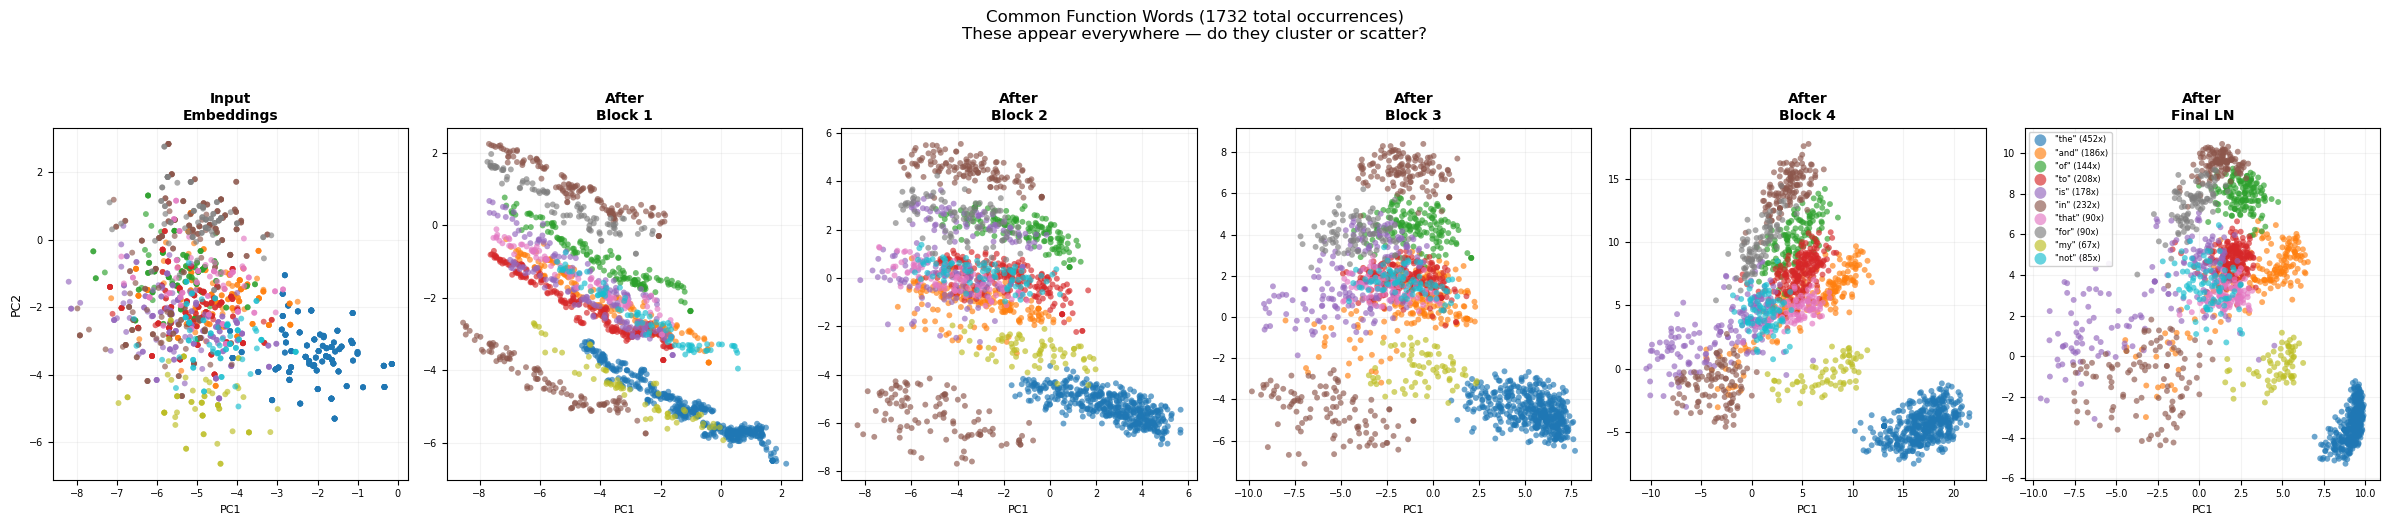


--- Common Function Words ---
         "the":  452 occurrences
         "and":  186 occurrences
          "of":  144 occurrences
          "to":  208 occurrences
          "is":  178 occurrences
          "in":  232 occurrences
        "that":   90 occurrences
         "for":   90 occurrences
          "my":   67 occurrences
         "not":   85 occurrences



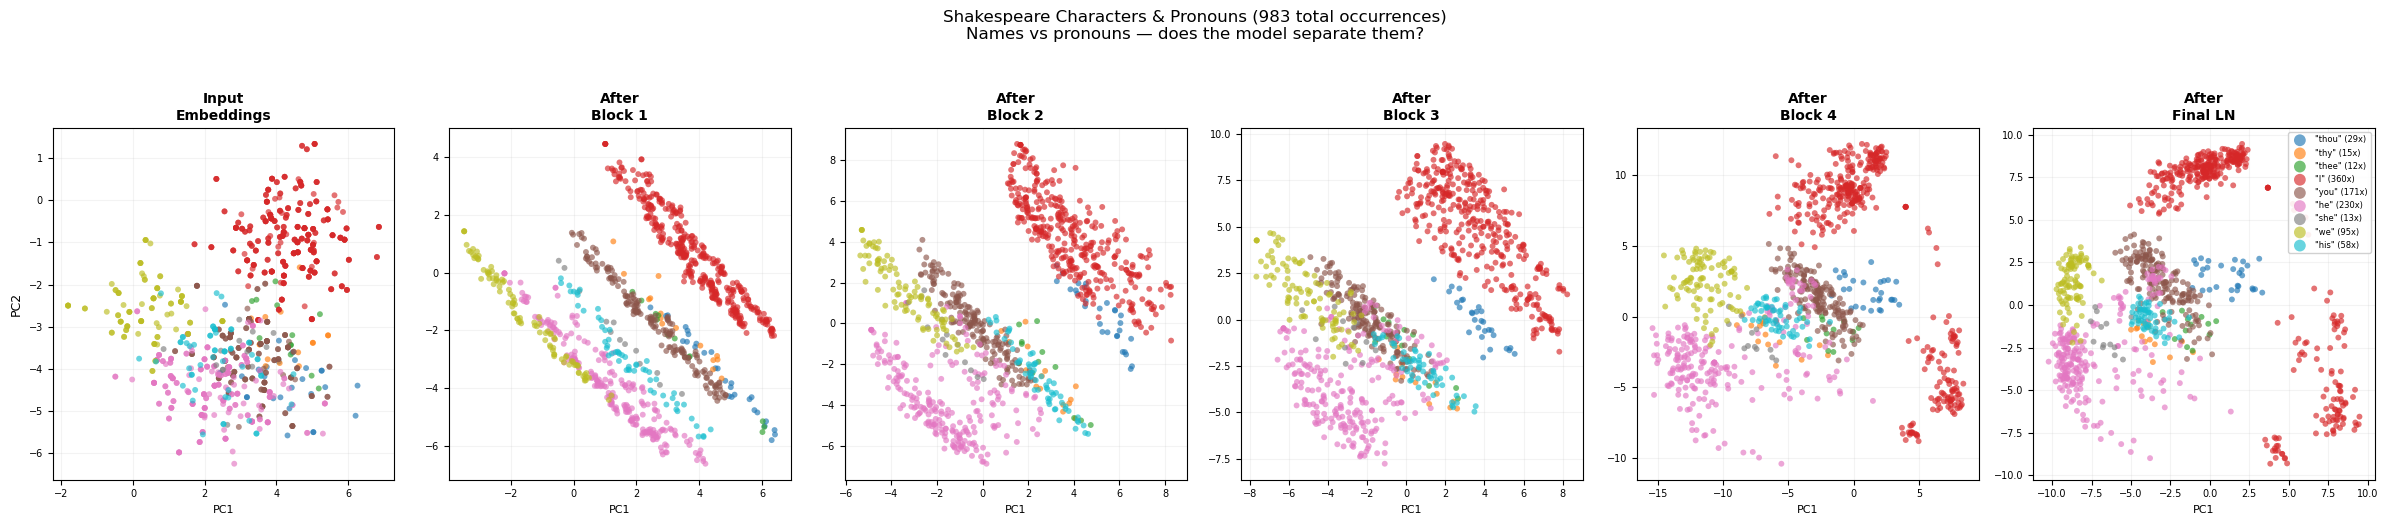


--- Shakespeare Characters & Pronouns ---
        "thou":   29 occurrences
         "thy":   15 occurrences
        "thee":   12 occurrences
           'I':  360 occurrences
         "you":  171 occurrences
          "he":  230 occurrences
         "she":   13 occurrences
          "we":   95 occurrences
         "his":   58 occurrences



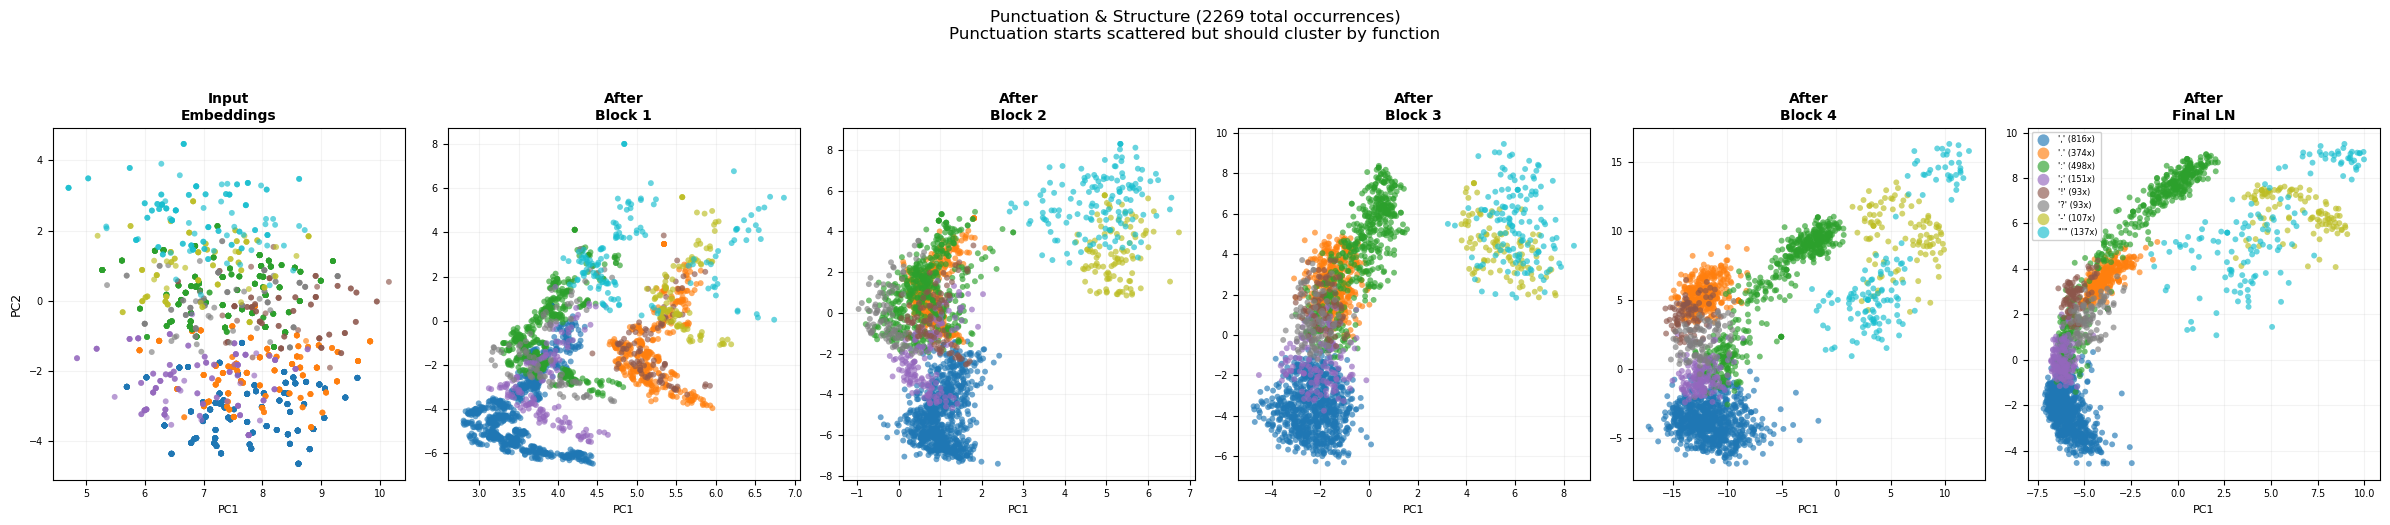


--- Punctuation & Structure ---
           ',':  816 occurrences
           '.':  374 occurrences
           ':':  498 occurrences
           ';':  151 occurrences
           '!':   93 occurrences
           '?':   93 occurrences
           '-':  107 occurrences
           "'":  137 occurrences



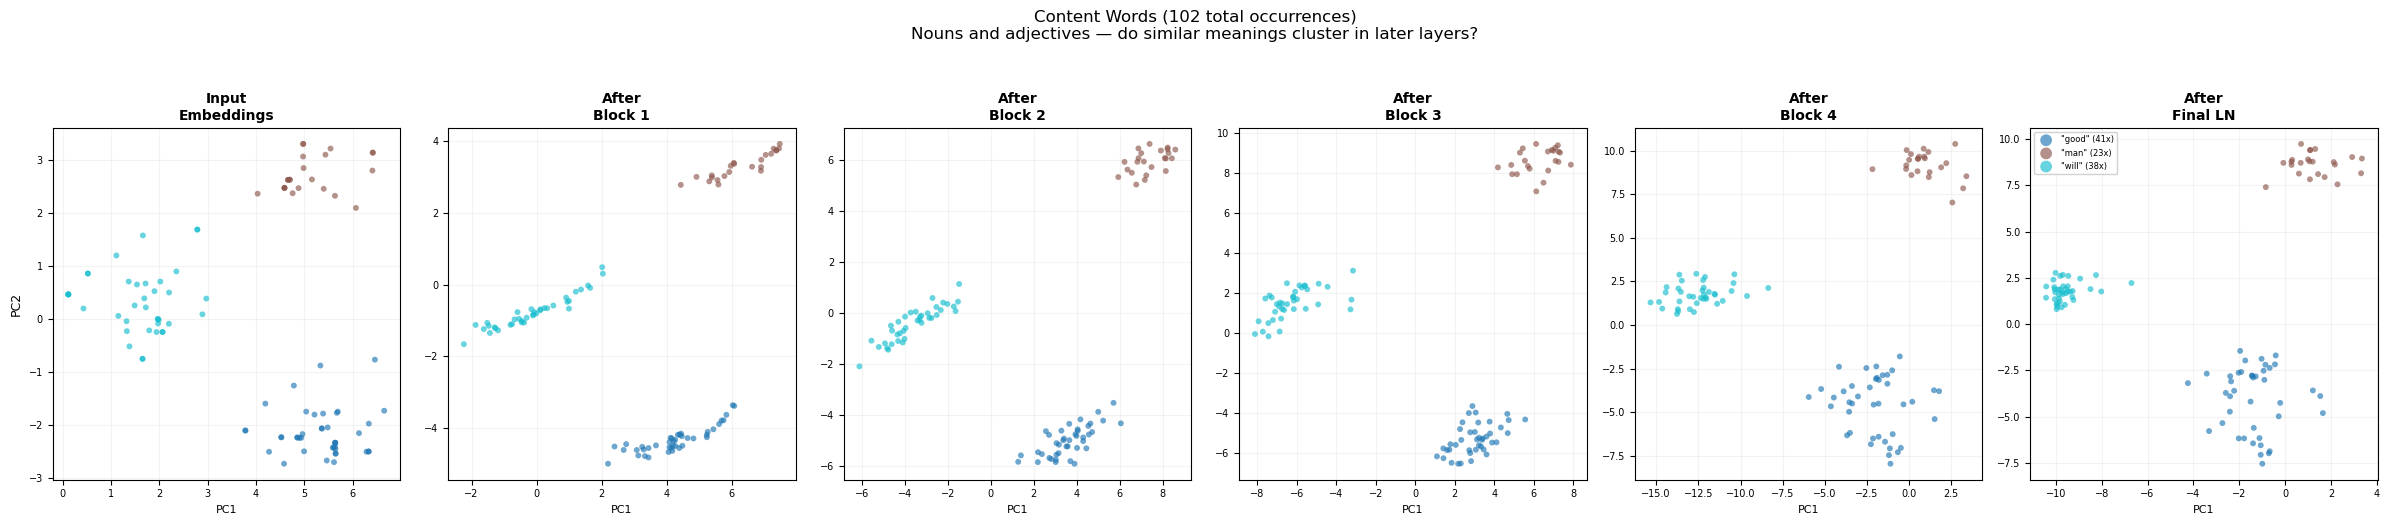


--- Content Words ---
        "good":   41 occurrences
         "man":   23 occurrences
        "will":   38 occurrences

KEY INSIGHT: Same color = same token across all panels.
  Input embeddings (left): same-colored dots are CLUSTERED (same vector)
  Final layer (right):     same-colored dots may SPREAD (different contexts)

  Tokens that serve similar grammatical roles may MERGE into clusters
  even though they started as completely different embeddings.
  This is the transformer building contextual representations.


In [36]:
# Visualize how specific token groups behave across layers.
# Each figure shows 10 tokens, ALL their occurrences, across all 6 layers.
# Same color = same token. Shared PCA per figure so you can track movement.

from collections import Counter

# Build a lookup: token string -> list of positions in the flat array
token_positions = {}
for i, tid in enumerate(all_ids_flat):
    tok_str = all_tokens[i].strip()
    if tok_str not in token_positions:
        token_positions[tok_str] = []
    token_positions[tok_str].append(i)

# Define 4 groups of 10 tokens to visualize
groups = [
    {
        'title': 'Common Function Words',
        'subtitle': 'These appear everywhere — do they cluster or scatter?',
        'tokens': ['the', 'and', 'of', 'to', 'is', 'in', 'that', 'for', 'my', 'not'],
    },
    {
        'title': 'Shakespeare Characters & Pronouns',
        'subtitle': 'Names vs pronouns — does the model separate them?',
        'tokens': ['ROMEO', 'thou', 'thy', 'thee', 'I', 'you', 'he', 'she', 'we', 'his'],
    },
    {
        'title': 'Punctuation & Structure',
        'subtitle': 'Punctuation starts scattered but should cluster by function',
        'tokens': [',', '.', ':', ';', '!', '?', '-', "'", '\n', '('],
    },
    {
        'title': 'Content Words',
        'subtitle': 'Nouns and adjectives — do similar meanings cluster in later layers?',
        'tokens': ['love', 'death', 'heart', 'night', 'day', 'good', 'man', 'time', 'come', 'will'],
    },
]

# Use tab10 for 10 clearly distinct colors
group_cmap = plt.cm.tab10

for g_idx, group in enumerate(groups):
    # Collect all positions for tokens in this group
    group_positions = {}  # tok_str -> list of flat indices
    for tok in group['tokens']:
        if tok in token_positions:
            group_positions[tok] = token_positions[tok]
    
    # Skip tokens not found
    found_tokens = [t for t in group['tokens'] if t in group_positions]
    if len(found_tokens) < 3:
        print(f"Skipping group '{group['title']}' — not enough tokens found")
        continue
    
    # Gather all indices we need for this group
    all_group_indices = []
    for tok in found_tokens:
        all_group_indices.extend(group_positions[tok])
    
    # Extract representations at these positions across all layers, do shared PCA
    group_reprs = []
    for layer_idx in range(n_layers_viz):
        lr = layer_representations[layer_idx][all_group_indices].float()
        group_reprs.append(lr)
    
    all_stacked = torch.cat(group_reprs, dim=0)
    all_centered = all_stacked - all_stacked.mean(dim=0)
    U, S, V = torch.pca_lowrank(all_centered, q=2)
    all_2d = (all_centered @ V[:, :2]).numpy()
    
    total_var = (S ** 2).sum().item()
    var_ratio = [(S[i] ** 2).item() / total_var for i in range(2)]
    
    n_group = len(all_group_indices)
    layer_coords = []
    for li in range(n_layers_viz):
        layer_coords.append(all_2d[li * n_group : (li + 1) * n_group])
    
    # Build color array: each token gets a distinct color
    tok_to_color_idx = {tok: i for i, tok in enumerate(found_tokens)}
    color_array = np.array([
        group_cmap(tok_to_color_idx[all_tokens[pos].strip()] / max(len(found_tokens) - 1, 1))
        for pos in all_group_indices
    ])
    
    # Plot: 1 row x 6 columns
    fig, axes = plt.subplots(1, n_layers_viz, figsize=(4 * n_layers_viz, 5))
    
    for col in range(n_layers_viz):
        ax = axes[col]
        coords = layer_coords[col]
        
        # Plot each token type separately for clean legend
        for tok_idx, tok in enumerate(found_tokens):
            mask = np.array([all_tokens[pos].strip() == tok for pos in all_group_indices])
            if mask.sum() == 0:
                continue
            color = group_cmap(tok_idx / max(len(found_tokens) - 1, 1))
            label_str = repr(tok) if tok in (',', '.', ':', ';', '!', '?', '-', "'", '\n', '(') else f'"{tok}"'
            count = mask.sum()
            ax.scatter(coords[mask, 0], coords[mask, 1],
                       c=[color], s=18, alpha=0.65, edgecolor='none',
                       label=f'{label_str} ({count}x)' if col == n_layers_viz - 1 else None,
                       zorder=3)
        
        ax.set_title(layer_labels[col], fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.15)
        ax.tick_params(labelsize=7)
        if col == 0:
            ax.set_ylabel(f'PC2', fontsize=9)
        ax.set_xlabel(f'PC1', fontsize=8)
    
    axes[-1].legend(fontsize=6, loc='best', framealpha=0.9, ncol=1, markerscale=2)
    
    total_dots = sum(len(group_positions[t]) for t in found_tokens)
    fig.suptitle(f'{group["title"]} ({total_dots} total occurrences)\n{group["subtitle"]}',
                 fontsize=12, y=1.04)
    plt.tight_layout()
    plt.show()
    
    # Print stats
    print(f"\n--- {group['title']} ---")
    for tok in found_tokens:
        n = len(group_positions[tok])
        label = repr(tok) if len(tok) <= 1 else f'"{tok}"'
        print(f"  {label:>12s}: {n:>4d} occurrences")
    print()

print("=" * 70)
print("KEY INSIGHT: Same color = same token across all panels.")
print("  Input embeddings (left): same-colored dots are CLUSTERED (same vector)")
print("  Final layer (right):     same-colored dots may SPREAD (different contexts)")
print()
print("  Tokens that serve similar grammatical roles may MERGE into clusters")
print("  even though they started as completely different embeddings.")
print("  This is the transformer building contextual representations.")

In [35]:
# Generate text from the 1-block and 4-block models
print("=" * 70)
print("TEXT GENERATION COMPARISON")
print("=" * 70)

torch.manual_seed(42)
print("\n--- 1-Block Transformer ---")
start = torch.zeros((1, 1), dtype=torch.long)
gen = model_1b.generate(start, max_new_tokens=250)
print(tokenizer.decode(gen[0].tolist()))

torch.manual_seed(42)
print("\n--- 4-Block Transformer ---")
start = torch.zeros((1, 1), dtype=torch.long)
gen = model_4b.generate(start, max_new_tokens=250)
print(tokenizer.decode(gen[0].tolist()))

print("\n" + "=" * 70)
print("The 4-block model should show more coherent structure:")
print("  - Better dialogue formatting (character names, colons, line breaks)")
print("  - More grammatical phrases")
print("  - Longer-range coherence")
print("Each additional layer gives the model another 'round of thinking'.")

TEXT GENERATION COMPARISON

--- 1-Block Transformer ---
 
Though thy beauty action and joy,
Whose fody heads well, nim the drask.
I'll knock Au and pale's are unwelling unst-

WARWICK:
What men, Come, put upon this an
To dead to child frensets; stande triumphs and to tell him.
Is' so drenage thy stabling spetisledess
In bloody thus sads and ange thushood be gone: you know
Burgh this good lords officians Pasterseaid,
Haves not the comes buckle your father's early
The wrong make himself with rustant
And mannife it hate that she
Dotew me ill clouds I desire thee,

--- 4-Block Transformer ---
  and hast thou mult bau arken.
I am reasoning Richard immort's name,
I do not live thy knear but order and Engl are unwell.

QUEEN MARGARET:
What most, Comefider, I come to thee,
Or do meaning thyself; these standers trial letchs.
Ah him may; but talk your knowage!

FRIAR EDWARD:
More far then thirty Jeazind that Greiodest you know
Bear you this, as you are: it ah in Pedgelace?

HUCESS OF ONORNE:
The

## 6. Ablation Comparison: The Full Picture

Let's bring together every model we've trained across Notebooks 2, 3, and 4. This is the reverse ablation study — starting from the simplest model and adding one component at a time.

### The Complete Build-Up

| Step | What We Added | Why It Helps |
|---|---|---|
| Bigram (NB 2) | Token embedding only | Baseline: predicts from current token alone |
| + Single-Head Attn (NB 3) | Position emb + 1 attention head | Can see context (one perspective) |
| + Multi-Head Attn (NB 3) | 4 parallel attention heads | Multiple perspectives on context |
| + FFN (NB 4) | Feed-forward network | Nonlinear processing of attended info |
| + LayerNorm (NB 4) | Layer normalization | Stable activations |
| + Residuals (NB 4) | Skip connections | Gradient highway, information preservation |
| x4 Depth (NB 4) | Stack 4 blocks | Hierarchical pattern learning |

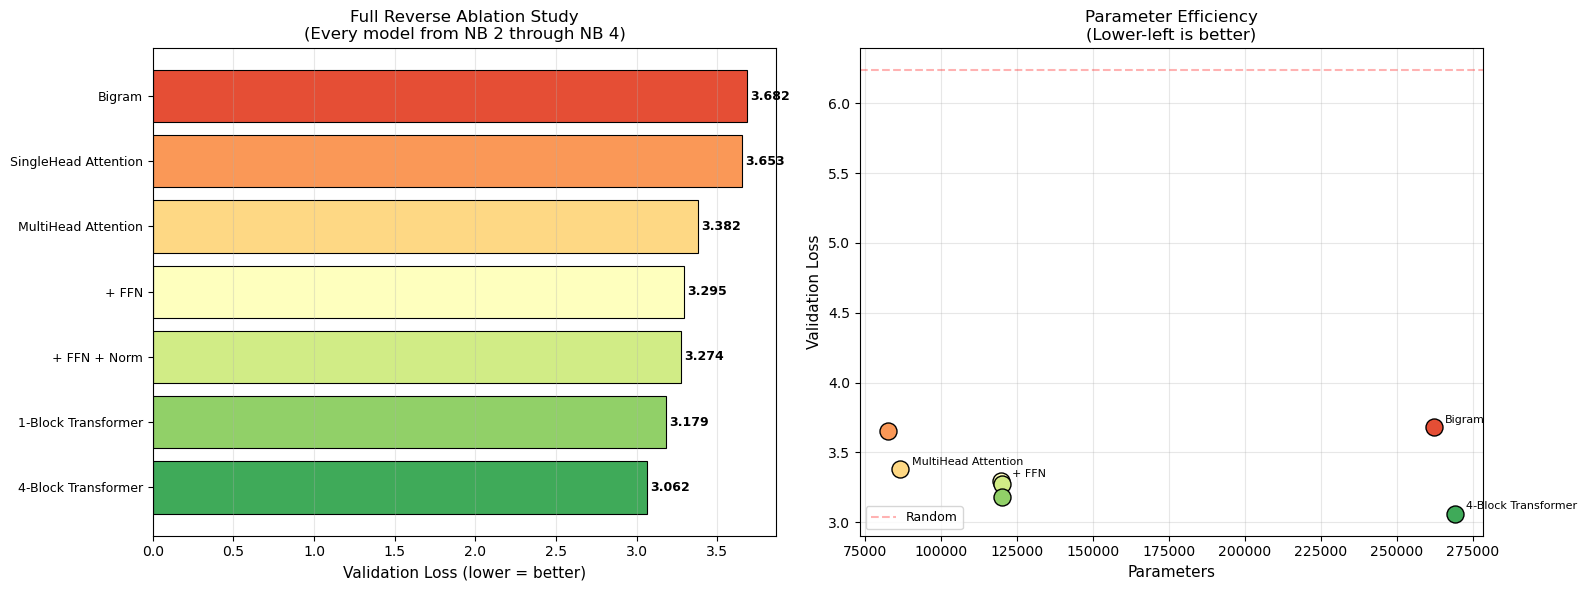


FULL REVERSE ABLATION: Component-by-Component Impact
Model                              Params   Val Loss  vs Bigram
--------------------------------------------------------------
Bigram                            262,144     3.6823    +0.0000
SingleHead Attention               82,432     3.6529    -0.0293
MultiHead Attention                86,528     3.3818    -0.3005
+ FFN                             119,616     3.2947    -0.3876
+ FFN + Norm                      119,872     3.2743    -0.4080
1-Block Transformer               120,000     3.1788    -0.5035
4-Block Transformer               269,184     3.0621    -0.6201
--------------------------------------------------------------
(Negative = improvement over bigram baseline)


In [27]:
# Comprehensive ablation visualization

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Full ablation bar chart with all models ---
ax = axes[0]

# Load all saved metrics + current notebook results
all_models = []
for m in all_metrics:
    all_models.append((m['model'], m['val_loss'], m['parameters']))

# Add current notebook models
current_models = [
    ('+ FFN', val_loss_ffn, n_params_ffn),
    ('+ FFN + Norm', val_loss_norm, n_params_norm),
    ('1-Block Transformer', val_loss_1b, n_params_1b),
    ('4-Block Transformer', val_loss_4b, n_params_4b),
]

# Sort all by val_loss descending (worst first)
combined = all_models + current_models
combined.sort(key=lambda x: x[1], reverse=True)

names = [c[0] for c in combined]
vals = [c[1] for c in combined]
params_list = [c[2] for c in combined]

# Color gradient from red (worst) to green (best)
n = len(combined)
colors_gradient = plt.cm.RdYlGn(np.linspace(0.15, 0.85, n))

bars = ax.barh(range(n), vals, color=colors_gradient, edgecolor='black', linewidth=0.8)
for i, (bar, v) in enumerate(zip(bars, vals)):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
            f'{v:.3f}', va='center', fontsize=9, fontweight='bold')

ax.set_yticks(range(n))
ax.set_yticklabels(names, fontsize=9)
ax.set_xlabel('Validation Loss (lower = better)', fontsize=11)
ax.set_title('Full Reverse Ablation Study\n(Every model from NB 2 through NB 4)', fontsize=12)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()  # best at bottom

# --- Parameter efficiency scatter ---
ax = axes[1]
for i, (name, val, params) in enumerate(combined):
    if params > 0:
        ax.scatter(params, val, s=150, color=colors_gradient[i],
                   edgecolor='black', linewidth=1, zorder=5)
        # Only label a few to avoid clutter
        if name in ['Bigram', '4-Block Transformer', 'MultiHead Attention', '+ FFN']:
            ax.annotate(name, (params, val),
                        textcoords='offset points', xytext=(8, 3), fontsize=8)

ax.set_xlabel('Parameters', fontsize=11)
ax.set_ylabel('Validation Loss', fontsize=11)
ax.set_title('Parameter Efficiency\n(Lower-left is better)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.axhline(y=random_loss, color='red', linestyle='--', alpha=0.3, label='Random')
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

# Print full table
print("\n" + "=" * 70)
print("FULL REVERSE ABLATION: Component-by-Component Impact")
print("=" * 70)
print(f"{'Model':<30} {'Params':>10} {'Val Loss':>10} {'vs Bigram':>10}")
print("-" * 62)
for name, val, params in sorted(combined, key=lambda x: x[1], reverse=True):
    delta = val - bigram_val
    params_str = f'{params:,}' if params > 0 else '---'
    print(f"{name:<30} {params_str:>10} {val:>10.4f} {delta:>+10.4f}")
print("-" * 62)
print("(Negative = improvement over bigram baseline)")

In [28]:
# Save all metrics for future notebooks
for model_name, val_loss, params in current_models:
    all_metrics = [m for m in all_metrics if m["model"] != model_name]
    all_metrics.append({
        "model": model_name,
        "parameters": params,
        "val_loss": val_loss,
        "d_model": d_model,
        "n_heads": n_heads,
        "d_ff": d_ff,
        "block_size": block_size,
    })

with open(metrics_path, "w") as f:
    json.dump(all_metrics, f, indent=2)

print("All metrics saved to ablation_metrics.json!")
print(f"\nTotal models tracked: {len(all_metrics)}")
for m in sorted(all_metrics, key=lambda x: x.get('val_loss', 99)):
    print(f"  {m['model']}: val_loss={m['val_loss']:.4f}, params={m['parameters']:,}")

All metrics saved to ablation_metrics.json!

Total models tracked: 7
  4-Block Transformer: val_loss=3.0621, params=269,184
  1-Block Transformer: val_loss=3.1788, params=120,000
  + FFN + Norm: val_loss=3.2743, params=119,872
  + FFN: val_loss=3.2947, params=119,616
  MultiHead Attention: val_loss=3.3818, params=86,528
  SingleHead Attention: val_loss=3.6529, params=82,432
  Bigram: val_loss=3.6823, params=262,144


## Summary

### What We Built

We assembled the **complete transformer block** by adding three components to the multi-head attention from Notebook 3:

| Component | Purpose | Key Property |
|---|---|---|
| **Feed-Forward Network** | Nonlinear processing of attended info | Expand to 4x dims, GELU activation, compress back |
| **Layer Normalization** | Stabilize activations for training | Normalizes to mean=0, std=1, with learned scale/shift |
| **Residual Connections** | Enable gradient flow in deep networks | x = x + sublayer(x) preserves information by default |

### The Complete Transformer Block

```
x = x + MultiHeadAttention(LayerNorm(x))
x = x + FeedForward(LayerNorm(x))
```

Two lines of code. This is the building block of GPT-2, GPT-3, GPT-4, LLaMA, Claude, and every other modern transformer language model.

### The Embedding Space Perspective

Each transformer block performs two operations on the token representations:

1. **Attention** moves tokens in embedding space by blending them with context (weighted sum of value vectors)
2. **FFN** moves tokens in embedding space through nonlinear computation (pushing to new regions no linear combination could reach)

The residual connection ensures these are **incremental adjustments** — each block nudges the representation rather than replacing it wholesale. Stacking 4 blocks means 4 rounds of adjustment, each building on the previous.

### What's Next: Notebook 5

We now have all the pieces of a transformer. Notebook 5 wraps everything into a clean, configurable **GPT model** with:
- Proper weight initialization
- Dropout for regularization
- Configurable number of layers, heads, dimensions
- Training at scale with the full hyperparameter setup

This is where we go from "understanding the components" to "building a real model."